<div style="width: 30%; clear: both;">
    <div style="float: left; width: 50%;">
       <img src="https://storage-prtl-co.imgix.net/endor/organisations/1358/logos/1670340670_logo-512x512px.png", align="left">
    </div>
</div>

<div style="float: right; width: 50%;">
    <p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo de Fin de Máster</p>
    <p style="margin: 0; text-align:right;">Máster en Ciencia de Datos</p>
    <p style="margin: 0; text-align:right; padding-button: 100px;">Métodos avanzados de agrupación de series temporales</p>
</div>

</div>
<div style="width: 100%; clear: both;">
<div style="width:100%;">&nbsp;</div>

In [1]:
from keras.callbacks import Callback
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.layers import Dense,Activation,Flatten
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import linkage, dendrogram

from scipy.spatial.distance import squareform
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, MDS
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler
from tqdm.autonotebook import tqdm
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import KernelKMeans
from tslearn.clustering import KShape
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.generators import random_walks
import cufflinks as cf
import math
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hac
import seaborn as sns
import warnings 

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import random

cf.go_offline()
plt.rcParams['figure.figsize'] = (30.0, 15.0)
warnings.filterwarnings('ignore')


C:\Users\DETPC\AppData\Local\Temp\ipykernel_17200\2082669479.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

### Adquisición de los datos


In [3]:
df = pd.read_csv('Q2026385_ST_CONSUMOS_ESPECIALIDADES_102.csv', sep=',')
# Número de registros
print('Número de registros:', len(df))
display(df.head())

# Unificar JOYERIAS VIP en JOYERIAS
df['Desc_Especialidad'] = df['Desc_Especialidad'].replace('JOYERIAS VIP', 'JOYERIAS')
df['Desc_Especialidad'] = df['Desc_Especialidad'].replace('SERVICIOS PUBLICO CON COMISION', 'SERVICIOS PUBLICOS')
df['Desc_Especialidad'] = df['Desc_Especialidad'].replace('LABORATORIOS DE PRUEBA (NO', 'LABORATORIOS DE PRUEBA')
df['Desc_Especialidad'] = df['Desc_Especialidad'].replace('SERVICIOS FINANCIEROS EXPRESS', 'SERVICIOS FINANCIEROS')
df['Desc_Especialidad'] = df['Desc_Especialidad'].replace('MERC. PEQUEÑAS, NOCIONES Y', 'MERC. PEQUEÑAS')

# Eliminar REFINANCIACION COMERCIAL
df = df[df['Desc_Especialidad'] != 'REFINANCIACION COMERCIAL']
df = df[df['Desc_Especialidad'] != 'DIRECT MARKETERS,NOT ELSEW']
df = df[df['Desc_Especialidad'] != 'SERV. TELEMARKETING(EXCLUY']
df = df[df['Desc_Especialidad'] != 'EQUIPOS COMERCIALES-NO DE']


# Total especialidades
print('Total especialidades:', len(df['Desc_Especialidad'].unique()))


Número de registros: 538550


,Desc_Especialidad,Fecha,Consumo
0,TELEFONIA Y COMUNICACION,2022-11-08,198917.6664
1,CONDOMINIOS,2019-10-07,66568.5660
2,GALERIAS DE ARTE,2021-01-28,958.4940
3,DISFRACES - ARRIENDO,2022-03-10,5.5080
4,DISCOTECAS,2018-12-23,289.3842


Total especialidades: 99


In [4]:
# Listado de especialidades en orden alfabético
print('Especialidades en orden alfabético:')
display(df['Desc_Especialidad'].unique())

# 

Especialidades en orden alfabético:


array(['TELEFONIA Y COMUNICACION', 'CONDOMINIOS', 'GALERIAS DE ARTE',
       'DISFRACES - ARRIENDO', 'DISCOTECAS', 'SERVICIOS PUBLICOS',
       'VENTA DE VEHICULOS', 'FINANCIAMIENTO MOTOS Y OTROS',
       'CORREO Y TRANSPORTE', 'PREPAGO Y PASIVOS', 'LAVANDERIAS',
       'SEGUROS', 'INMOBILIARIAS', 'BARES',
       'CALZADO Y ARTICULOS DE CUERO', 'VENTAS POR INTERNET',
       'INFORMATICA', 'RESTAURANTES', 'DISTRIBUIDOR DE CAMPINGS',
       'FARMACIAS Y PERFUMERIAS', 'GASOLINERAS',
       'ALMACEN POR DEPARTAMENTOS', 'CLINICAS', 'ELECTRODOMESTICOS',
       'JUGUETERIAS', 'RELOJERIAS', 'SUPERMERCADOS',
       'SERVICIOS FUNERARIOS', 'MUEBLES', 'JOYERIAS', 'SALAS DE BELLEZA',
       'BIENES DURABLES NO CLASIF.', 'SERVICIOS COMERCIALES',
       'SUSCRIPCIONES', 'CARPAS Y TOLDOS', 'COMIDA RAPIDA',
       'CRISTALERIAS Y PORCELANAS', 'COMPRAS GUBERNAMENTALES',
       'PISCINAS-ACCESORIOS SERVIC', 'SERVICIOS DE PUBLICIDAD',
       'MERC. PEQUEÑAS', 'ARTICULOS PARA NIñOS',
       'FUNDACIONES Y

### Preprocesamiento de los datos

In [5]:
# Sumar consumo por especialidad y fecha
df['Fecha'] = pd.to_datetime(df['Fecha'])

df = df.groupby(['Fecha', 'Desc_Especialidad']).agg({'Consumo': 'sum'}).reset_index()

# Ordenar por fecha
df = df.sort_values(by=['Fecha'])

print('Número de registros antes de agregar fechas', len(df))

# Colocar fecha diaria por especialidad
for i in df['Desc_Especialidad'].unique():
    dates = pd.date_range(start=df['Fecha'].min(), end=df['Fecha'].max(), freq='D')
    df_dates = pd.DataFrame(dates, columns=['Fecha'])
    df_dates['Desc_Especialidad'] = i
    df = pd.concat([df, df_dates])
df = df.sort_values(by=['Fecha', 'Desc_Especialidad'])

df = df.groupby(['Fecha', 'Desc_Especialidad']).agg({'Consumo': 'sum'}).reset_index()

print('Número de registros después de agregar fechas:', len(df))
display(df.head(15))


Número de registros antes de agregar fechas 143827
Número de registros después de agregar fechas: 187768


,Fecha,Desc_Especialidad,Consumo
0,2018-01-01,ACADEMIAS,7942.9236
1,2018-01-01,AG.EMPLEO-SERVICIO DE AYUD,0.0000
2,2018-01-01,AGENCIAS DE VIAJES,13921.3476
3,2018-01-01,ALMACEN POR DEPARTAMENTOS,49810.2924
4,2018-01-01,ALMACENES DE DISCOS,0.0000
5,2018-01-01,ALMACENES DE TELAS,975.1812
6,2018-01-01,ALQUILER DE AUTOS,393.6384
7,2018-01-01,ARTES GRAFICAS,68.1870
8,2018-01-01,ARTESANIAS Y FOLKLORE,1085.1066
9,2018-01-01,ARTICULOS DEPORTIVOS,1346.4408


In [6]:

# Eliminar la columna de índice
df = df.set_index('Fecha')
# Eliminar año 2020
df = df[df.index.year != 2020]
# Ordenar por fecha
df = df.sort_index()

print( 'Número de registros:', len(df) )
df.head()


Número de registros: 151900


,Desc_Especialidad,Consumo
Fecha,,
2018-01-01,ACADEMIAS,7942.9236
2018-01-01,AG.EMPLEO-SERVICIO DE AYUD,0.0000
2018-01-01,AGENCIAS DE VIAJES,13921.3476
2018-01-01,ALMACEN POR DEPARTAMENTOS,49810.2924
2018-01-01,ALMACENES DE DISCOS,0.0000


In [7]:
LIST_ESPECIALIDADES = df['Desc_Especialidad'].unique()
# Eliminar Consumo 0
df = df[df['Consumo'] > 0 ]
print( 'Número de registros:', len(df) )

Número de registros: 117337


In [8]:
## Eliminar especialidades que no tienen consumos en 2023
# df_2023 = df[df.index.year == 2023]

# # Identifica las especialidades que tienen consumos en 2023
# especialidades_con_consumos_2023 = df_2023['Desc_Especialidad'].unique()

# # Filtra el DataFrame original para retener solo las especialidades con consumos en 2023
# df_final = df[df['Desc_Especialidad'].isin(especialidades_con_consumos_2023)]

# len(especialidades_con_consumos_2023)

In [9]:

# Top 10 de las especialidades más consumidas
top10 = df.groupby('Desc_Especialidad').sum().sort_values('Consumo', ascending=False).head(10)
top10 = top10.reset_index()
top10 = top10['Desc_Especialidad'].tolist()
top10

['COMPRAS EXTERIOR',
 'SERVICIOS FINANCIEROS',
 'SUPERMERCADOS',
 'ACADEMIAS',
 'REFINANCIACION',
 'SERVICIOS PUBLICOS',
 'SEGUROS',
 'TELEFONIA Y COMUNICACION',
 'LINEAS AEREAS',
 'FERRETERIAS Y CONSTRUCCION']

In [10]:
# Descripitivos del consumo
display(df['Consumo'].describe())

# Descriptivo del top 10 de especialidades
df[df['Desc_Especialidad'].isin(top10)].groupby('Desc_Especialidad').describe()



count    1.173370e+05
mean     1.844910e+05
std      4.963195e+05
min      2.448000e-01
25%      4.223932e+03
50%      2.721449e+04
75%      1.324024e+05
max      1.418819e+07
Name: Consumo, dtype: float64

Consumo                                          \
                             count          mean           std         min   
Desc_Especialidad                                                            
ACADEMIAS                   1549.0  9.204613e+05  9.242705e+05    359.0808   
COMPRAS EXTERIOR            1083.0  2.842399e+06  1.702070e+06  15577.9602   
FERRETERIAS Y CONSTRUCCION  1548.0  3.868984e+05  1.014745e+05   5351.4402   
LINEAS AEREAS               1548.0  4.250224e+05  3.182496e+05   1370.0436   
REFINANCIACION              1449.0  9.359729e+05  8.531880e+05     54.1110   
SEGUROS                     1549.0  6.368304e+05  7.114589e+05   1272.0012   
SERVICIOS FINANCIEROS       1548.0  1.469826e+06  1.121747e+06   1326.0000   
SERVICIOS PUBLICOS          1549.0  8.001531e+05  6.442344e+05     56.3856   
SUPERMERCADOS               1550.0  1.418885e+06  7.611434e+05    138.3426   
TELEFONIA Y COMUNICACION    1550.0  5.432200e+05  7.071141e+05     27.3360   

                                                                      \
                                     25%           50%           75%   
Desc_Especialidad                                                      
ACADEMIAS                   1.785917e+05  7.107906e+05  1.283758e+06   
COMPRAS EXTERIOR            1.906961e+06  2.249811e+06  2.745031e+06   
FERRETERIAS Y CONSTRUCCION  3.295906e+05  4.069838e+05  4.527523e+05   
LINEAS AEREAS               8.901336e+04  4.450159e+05  6.690608e+05   
REFINANCIACION              2.578364e+05  7.565607e+05  1.393817e+06   
SEGUROS                     1.584585e+05  5.199958e+05  7.835010e+05   
SERVICIOS FINANCIEROS       1.327151e+05  1.642172e+06  2.248315e+06   
SERVICIOS PUBLICOS          2.444405e+04  8.926248e+05  1.170786e+06   
SUPERMERCADOS               1.103775e+06  1.290780e+06  1.583805e+06   
TELEFONIA Y COMUNICACION    1.028461e+05  2.087405e+05  7.233743e+05   

                                          
                                     max  
Desc_Especialidad                         
ACADEMIAS                   8.725906e+06  
COMPRAS EXTERIOR            1.418819e+07  
FERRETERIAS Y CONSTRUCCION  7.614312e+05  
LINEAS AEREAS               1.725650e+06  
REFINANCIACION              4.747335e+06  
SEGUROS                     4.296104e+06  
SERVICIOS FINANCIEROS       5.359238e+06  
SERVICIOS PUBLICOS          4.248984e+06  
SUPERMERCADOS               7.362651e+06  
TELEFONIA Y COMUNICACION    4.302797e+06

In [11]:
# Datos atípicos por especialidad (fuera del rango intercuartílico)
for especialidad in LIST_ESPECIALIDADES:
    #print(especialidad, df[df['Desc_Especialidad'] == especialidad]['Consumo'].quantile(0.25), df[df['Desc_Especialidad'] == especialidad]['Consumo'].quantile(0.75))
   #print(df[df['Desc_Especialidad'] == especialidad]['Consumo'].quantile(0.75) - df[df['Desc_Especialidad'] == especialidad]['Consumo'].quantile(0.25))
    print("=====================================")
    print('ESPECIALIDAD: ', especialidad)
    q1 = df[df['Desc_Especialidad'] == especialidad]['Consumo'].quantile(0.25)
    q3 = df[df['Desc_Especialidad'] == especialidad]['Consumo'].quantile(0.75)
    iqr = q3 - q1
    limit_inf = q1 - 1.5 * iqr
    limit_sup = q3 + 1.5 * iqr
    # Ordenar de mayor a menor la cantidad de registros atípicos
    print(df[(df['Desc_Especialidad'] == especialidad) & ((df['Consumo'] < limit_inf) | (df['Consumo'] > limit_sup))].groupby('Desc_Especialidad').count().sort_values('Consumo', ascending=False))
    print('Porcentaje de registros atípicos: ', df[(df['Desc_Especialidad'] == especialidad) & ((df['Consumo'] < limit_inf) | (df['Consumo'] > limit_sup))].shape[0] / df[df['Desc_Especialidad'] == especialidad].shape[0] * 100)


ESPECIALIDAD:  ACADEMIAS
                   Consumo
Desc_Especialidad         
ACADEMIAS               61
Porcentaje de registros atípicos:  3.9380245319561005
ESPECIALIDAD:  AG.EMPLEO-SERVICIO DE AYUD
                            Consumo
Desc_Especialidad                  
AG.EMPLEO-SERVICIO DE AYUD       18
Porcentaje de registros atípicos:  10.650887573964498
ESPECIALIDAD:  AGENCIAS DE VIAJES
                    Consumo
Desc_Especialidad          
AGENCIAS DE VIAJES       10
Porcentaje de registros atípicos:  0.6455777921239509
ESPECIALIDAD:  ALMACEN POR DEPARTAMENTOS
                           Consumo
Desc_Especialidad                 
ALMACEN POR DEPARTAMENTOS      118
Porcentaje de registros atípicos:  7.617817947062622
ESPECIALIDAD:  ALMACENES DE DISCOS
                     Consumo
Desc_Especialidad           
ALMACENES DE DISCOS       80
Porcentaje de registros atípicos:  5.184705119896306
ESPECIALIDAD:  ALMACENES DE TELAS
                    Consumo
Desc_Especialidad          


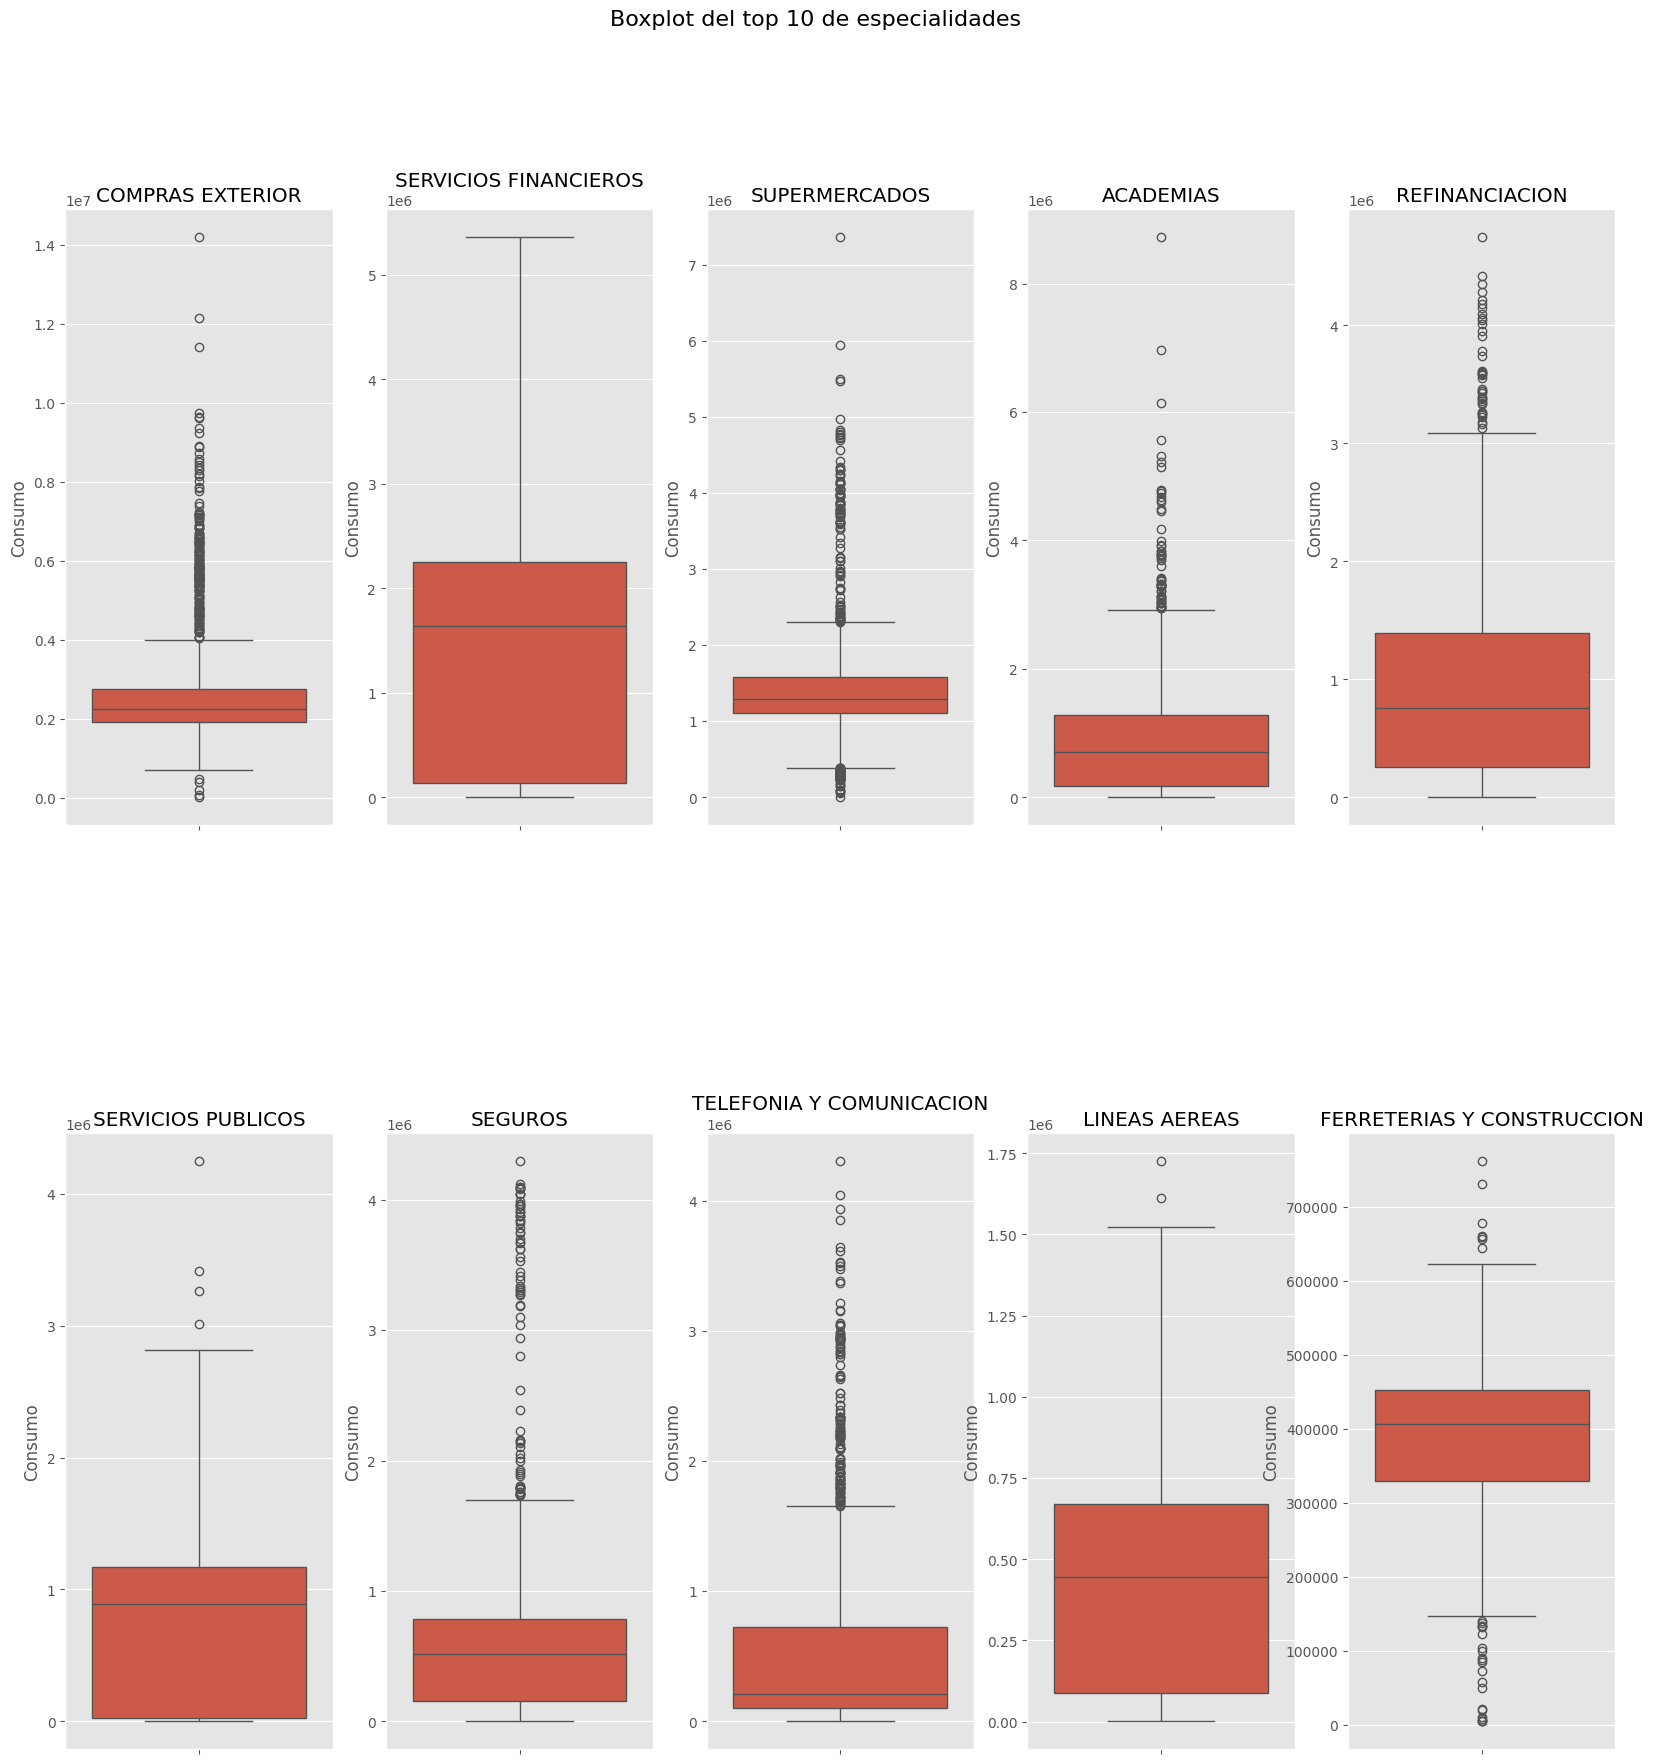

In [12]:
# Caja y bigotes para el top 10 de especialidades
plot_rows = 2
plot_cols = 5
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Boxplot del top 10 de especialidades', fontsize=16)
for i, especialidad in enumerate(top10):
    sns.boxplot(ax=axes[i // plot_cols, i % plot_cols], data=df[df['Desc_Especialidad'] == especialidad], x='Desc_Especialidad', y='Consumo')
    axes[i // plot_cols, i % plot_cols].set_title(especialidad)
    axes[i // plot_cols, i % plot_cols].set_xlabel('')
    axes[i // plot_cols, i % plot_cols].set_ylabel('Consumo')
    axes[i // plot_cols, i % plot_cols].set_xticklabels('')
plt.show()



In [13]:
# Impuntación de datos atípicos por especialidad con la mediana
for especialidad in LIST_ESPECIALIDADES:
    q1 = df[df['Desc_Especialidad'] == especialidad]['Consumo'].quantile(0.25)
    q3 = df[df['Desc_Especialidad'] == especialidad]['Consumo'].quantile(0.75)
    iqr = q3 - q1
    limit_inf = q1 - 1.5 * iqr
    limit_sup = q3 + 1.5 * iqr
    df.loc[(df['Desc_Especialidad'] == especialidad) & ((df['Consumo'] < limit_inf) | (df['Consumo'] > limit_sup)), 'Consumo'] = df[df['Desc_Especialidad'] == especialidad]['Consumo'].mean()


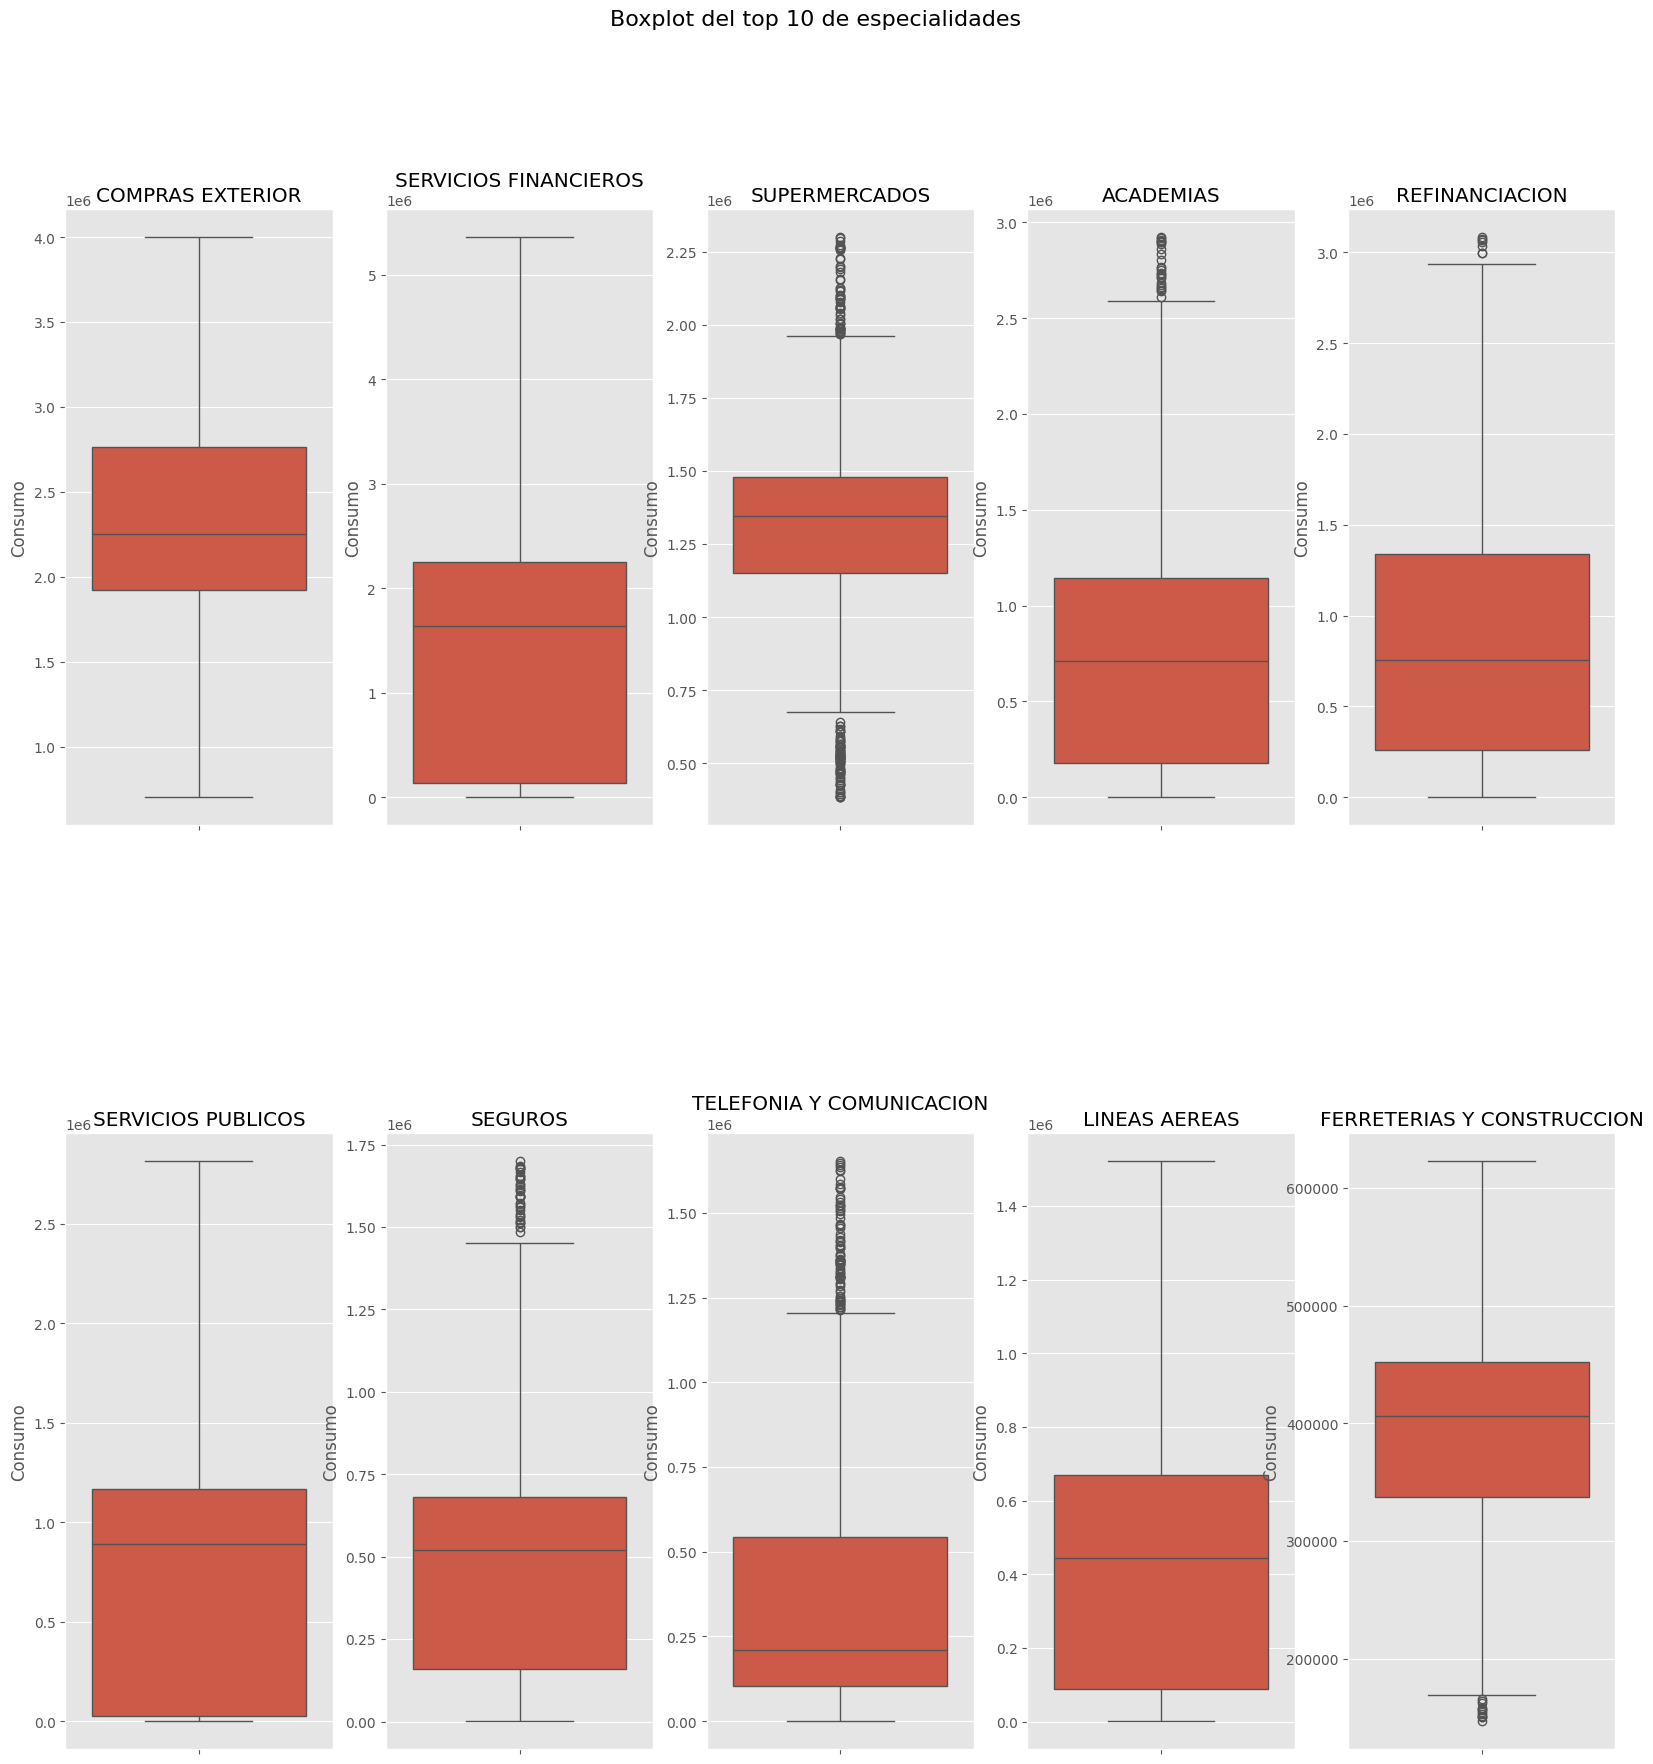

In [14]:
# Caja y bigotes para el top 10 de especialidades
plot_rows = 2
plot_cols = 5
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Boxplot del top 10 de especialidades', fontsize=16)
for i, especialidad in enumerate(top10):
    sns.boxplot(ax=axes[i // plot_cols, i % plot_cols], data=df[df['Desc_Especialidad'] == especialidad], x='Desc_Especialidad', y='Consumo')
    axes[i // plot_cols, i % plot_cols].set_title(especialidad)
    axes[i // plot_cols, i % plot_cols].set_xlabel('')
    axes[i // plot_cols, i % plot_cols].set_ylabel('Consumo')
    axes[i // plot_cols, i % plot_cols].set_xticklabels('')
plt.show()



In [15]:
# Descripitivos del consumo
display(df['Consumo'].describe())

# Descriptivo del top 10 de especialidades en entero
df[df['Desc_Especialidad'].isin(top10)].groupby('Desc_Especialidad').describe()




count    1.173370e+05
mean     1.676744e+05
std      4.040090e+05
min      2.448000e-01
25%      3.955234e+03
50%      2.620275e+04
75%      1.260345e+05
max      5.359238e+06
Name: Consumo, dtype: float64

Consumo                                           \
                             count          mean           std          min   
Desc_Especialidad                                                             
ACADEMIAS                   1549.0  8.050044e+05  6.766032e+05     359.0808   
COMPRAS EXTERIOR            1083.0  2.268676e+06  5.283038e+05  703543.4802   
FERRETERIAS Y CONSTRUCCION  1548.0  3.898148e+05  9.224139e+04  147023.8200   
LINEAS AEREAS               1548.0  4.234162e+05  3.150839e+05    1370.0436   
REFINANCIACION              1449.0  8.623991e+05  7.188159e+05      54.1110   
SEGUROS                     1549.0  5.141725e+05  3.939434e+05    1272.0012   
SERVICIOS FINANCIEROS       1548.0  1.469826e+06  1.121747e+06    1326.0000   
SERVICIOS PUBLICOS          1549.0  7.932213e+05  6.291376e+05      56.3856   
SUPERMERCADOS               1550.0  1.331075e+06  3.262301e+05  384143.5362   
TELEFONIA Y COMUNICACION    1550.0  3.783079e+05  3.713215e+05      27.3360   

                                                                      \
                                     25%           50%           75%   
Desc_Especialidad                                                      
ACADEMIAS                   1.785917e+05  7.107906e+05  1.146073e+06   
COMPRAS EXTERIOR            1.920235e+06  2.254228e+06  2.764339e+06   
FERRETERIAS Y CONSTRUCCION  3.375235e+05  4.059929e+05  4.520238e+05   
LINEAS AEREAS               8.901336e+04  4.442463e+05  6.685525e+05   
REFINANCIACION              2.578364e+05  7.565607e+05  1.336650e+06   
SEGUROS                     1.584585e+05  5.199958e+05  6.815873e+05   
SERVICIOS FINANCIEROS       1.327151e+05  1.642172e+06  2.248315e+06   
SERVICIOS PUBLICOS          2.444405e+04  8.912856e+05  1.168567e+06   
SUPERMERCADOS               1.152405e+06  1.344576e+06  1.478448e+06   
TELEFONIA Y COMUNICACION    1.028461e+05  2.087405e+05  5.432200e+05   

                                          
                                     max  
Desc_Especialidad                         
ACADEMIAS                   2.923448e+06  
COMPRAS EXTERIOR            4.000092e+06  
FERRETERIAS Y CONSTRUCCION  6.229302e+05  
LINEAS AEREAS               1.522065e+06  
REFINANCIACION              3.084603e+06  
SEGUROS                     1.699562e+06  
SERVICIOS FINANCIEROS       5.359238e+06  
SERVICIOS PUBLICOS          2.814597e+06  
SUPERMERCADOS               2.300324e+06  
TELEFONIA Y COMUNICACION    1.653019e+06

In [16]:

# Desc_Especialidad como lista y valores únicos
ESPECIALIDAD = df['Desc_Especialidad'].unique().tolist()

# Nuevo DF con los consumos por periodo
df_Frec = df.groupby([pd.Grouper(freq='1D'), 'Desc_Especialidad']).sum()
df_Frec['Periodo'] = df_Frec.index.get_level_values(0).strftime('%Y-%m')





In [17]:
# Escalar los consumos con min-max según la especialidad
df_Frec['Consumo'] = df_Frec.groupby('Desc_Especialidad')['Consumo'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# Ordenar por Desc_Especialidad y periodo
df_Frec = df_Frec.sort_values(by=['Desc_Especialidad', 'Periodo'])
# Sin notacion cientifica
pd.options.display.float_format = '{:.2f}'.format
print('Dimension', df_Frec.shape)


# Eliminar el index de Desc_Especialidad
df_Frec = df_Frec.reset_index(level='Desc_Especialidad')
df_Frec.tail()

print('Cantidad de especialidades:', len(df_Frec['Desc_Especialidad'].unique()))


Dimension (117337, 2)
Cantidad de especialidades: 98


### Análisis descriptivo

In [18]:
# Estadísticos descritivos solo de consumo
df_Frec['Consumo'].describe()

count   117337.00
mean         0.38
std          0.22
min          0.00
25%          0.22
50%          0.38
75%          0.53
max          1.00
Name: Consumo, dtype: float64

## Aplicaciones de los modelos

### Identificar el número de clusters

In [19]:
# Utilizamos el método de la raíz cuadrada para determinar el número de clusters
cluster_count = math.ceil(math.sqrt(len(df_Frec['Desc_Especialidad'].unique())))
print('Número de clusters:', cluster_count)

Número de clusters: 10


In [20]:
# Transponer la tabla para que Desc_Especialidad sean las columnas
df_Frec = df_Frec.pivot(columns='Desc_Especialidad', values='Consumo')

# Reemplazar los NaN por 0
df_Frec = df_Frec.fillna(0)
print('Dimension', df_Frec.shape)
df_Frec.head()

Dimension (1550, 98)


Desc_Especialidad,ACADEMIAS,AG.EMPLEO-SERVICIO DE AYUD,AGENCIAS DE VIAJES,ALMACEN POR DEPARTAMENTOS,ALMACENES DE DISCOS,ALMACENES DE TELAS,ALQUILER DE AUTOS,ARTES GRAFICAS,ARTESANIAS Y FOLKLORE,ARTICULOS DEPORTIVOS,...,SUSCRIPCIONES,TELEFONIA Y COMUNICACION,TIEMPO COMPARTIDO,TIENDA DE ALQUILER DE VIDE,TIENDA DE MASCOTAS Y VETERINAR,VENTA CATALOGO,VENTA DE VEHICULOS,VENTA PUERTA A PUERTA,VENTA Y RENTA DE MAQUINAS,VENTAS POR INTERNET
Fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.00,0.00,0.05,0.10,0.00,0.03,0.04,0.00,0.20,0.00,...,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00
2018-01-02,0.18,0.00,0.14,0.53,0.21,0.31,0.16,0.15,0.87,0.52,...,0.67,0.33,0.90,0.00,0.11,0.00,0.45,0.00,0.00,0.00
2018-01-03,0.18,0.00,0.19,0.42,0.50,0.52,0.48,0.15,0.51,0.11,...,0.31,0.37,0.60,0.24,0.39,0.04,0.33,0.00,0.00,0.00
2018-01-04,0.22,0.00,0.36,0.34,0.29,0.33,0.20,0.30,0.31,0.46,...,0.36,0.09,0.77,0.09,0.27,0.01,0.37,0.00,0.00,0.00
2018-01-05,0.24,0.00,0.23,0.26,0.89,0.41,0.24,0.20,0.20,0.22,...,0.73,0.71,0.75,0.00,0.26,0.04,0.15,0.00,0.00,0.00


In [21]:
# GRAFICAR ACADEMIAS
df_Frec['ACADEMIAS'].iplot(kind='line', title='ACADEMIAS', xTitle='Periodo', yTitle='Consumo', color='blue')


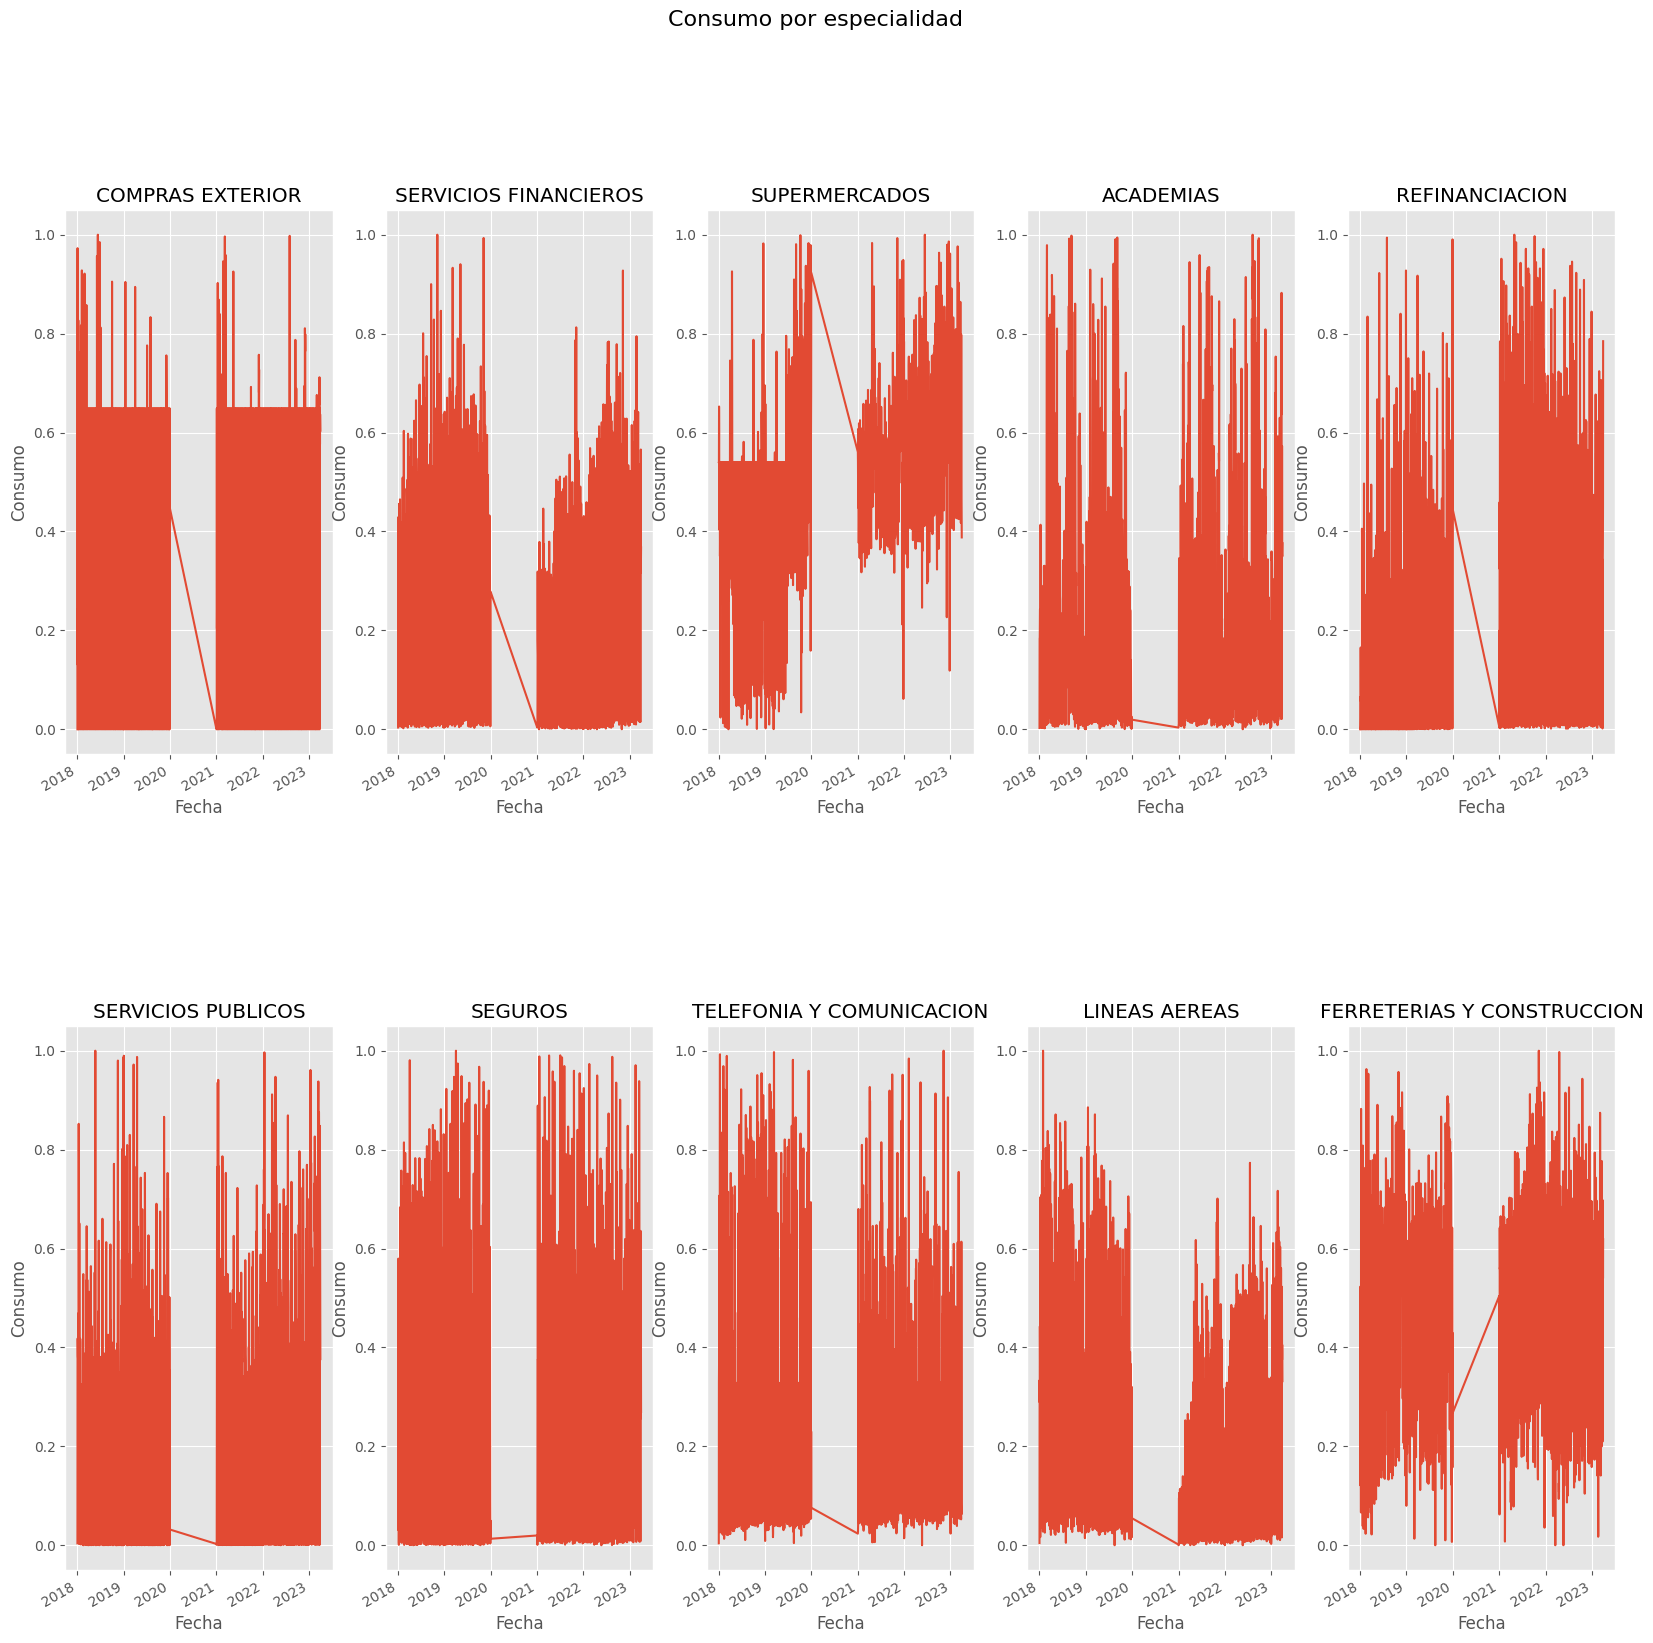

In [22]:
# plot del top 10 de especialidades
plot_rows = 2
plot_cols = 5
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Consumo por especialidad', fontsize=16)
for i, especialidad in enumerate(top10):
    df_Frec[especialidad].plot(ax=axes[i // plot_cols, i % plot_cols], title=especialidad)
    axes[i // plot_cols, i % plot_cols].set_xlabel('Fecha')
    axes[i // plot_cols, i % plot_cols].set_ylabel('Consumo')
    

In [23]:
# Descrptivos del top 10 de especialidades
df_Frec[top10].describe()



Desc_Especialidad,COMPRAS EXTERIOR,SERVICIOS FINANCIEROS,SUPERMERCADOS,ACADEMIAS,REFINANCIACION,SERVICIOS PUBLICOS,SEGUROS,TELEFONIA Y COMUNICACION,LINEAS AEREAS,FERRETERIAS Y CONSTRUCCION
count,1550.00,1550.00,1550.00,1550.00,1550.00,1550.00,1550.00,1550.00,1550.00,1550.00
mean,0.33,0.27,0.49,0.28,0.26,0.28,0.30,0.23,0.28,0.51
std,0.26,0.21,0.17,0.23,0.24,0.22,0.23,0.22,0.21,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.02,0.40,0.06,0.04,0.01,0.09,0.06,0.06,0.40
50%,0.39,0.31,0.50,0.24,0.21,0.32,0.31,0.13,0.29,0.54
75%,0.53,0.42,0.57,0.39,0.42,0.42,0.40,0.33,0.44,0.64
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [24]:
# fig, axes = plt.subplots(nrows=27, ncols=3, figsize=(25, 70))
# for i in range(0, len(ESPECIALIDAD)):
#     ax = df_Frec[ESPECIALIDAD[i]].plot(ax=axes[i//3, i%3], title=ESPECIALIDAD[i])
#     ax.set_xlabel("Fecha")
#     ax.set_ylabel("Consumo")
# plt.tight_layout()
# plt.show()


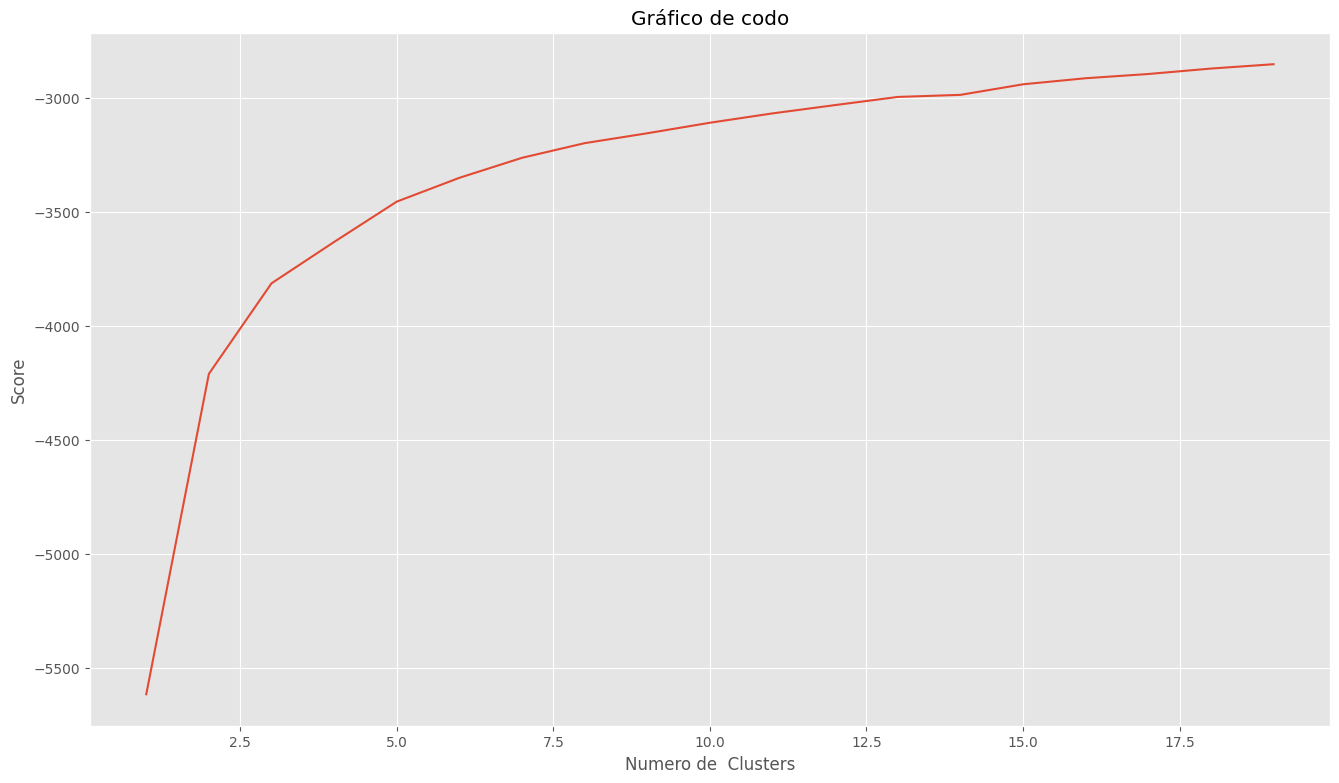

In [25]:
# grafico de codo
X = np.array(df_Frec)
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Numero de  Clusters')
plt.ylabel('Score')
plt.title('Gráfico de codo')

plt.show()

In [26]:
# # Utilizamos el método de la raíz cuadrada para determinar el número de clusters
cluster_count = math.ceil(math.sqrt(len(df_Frec.columns))) 
print("El número de clusters es: ", cluster_count)                    


El número de clusters es:  10


In [27]:
cluster_count = 10

In [28]:
# Transformo la tabla en un array
X = df_Frec.to_numpy()
# Transpongo el array para que las filas sean las series temporales
X = X.T
X.shape

(98, 1550)

### TimeSeriesKMeans

Resultados de K-Means de series temporales:
[ 7  2  5 10  8  5  8  8  5  9 10 10  3 10  8  2 10  2  7  5  4  8  1  3
  9  7  1  4  7  8  5  6  6  2 10  8  9  9  4  2  8  5  8  1  8  3  9  3
  2  3  6 10 10  2  3  3  8  1  2  2  2 10  2  3  7  2  7  1  2  6  7  8
  2  4  3 10  1  7  7  7  1  8  7  9  1  4  4  4  1  6  5  7  3  7  8  2
  2  2]


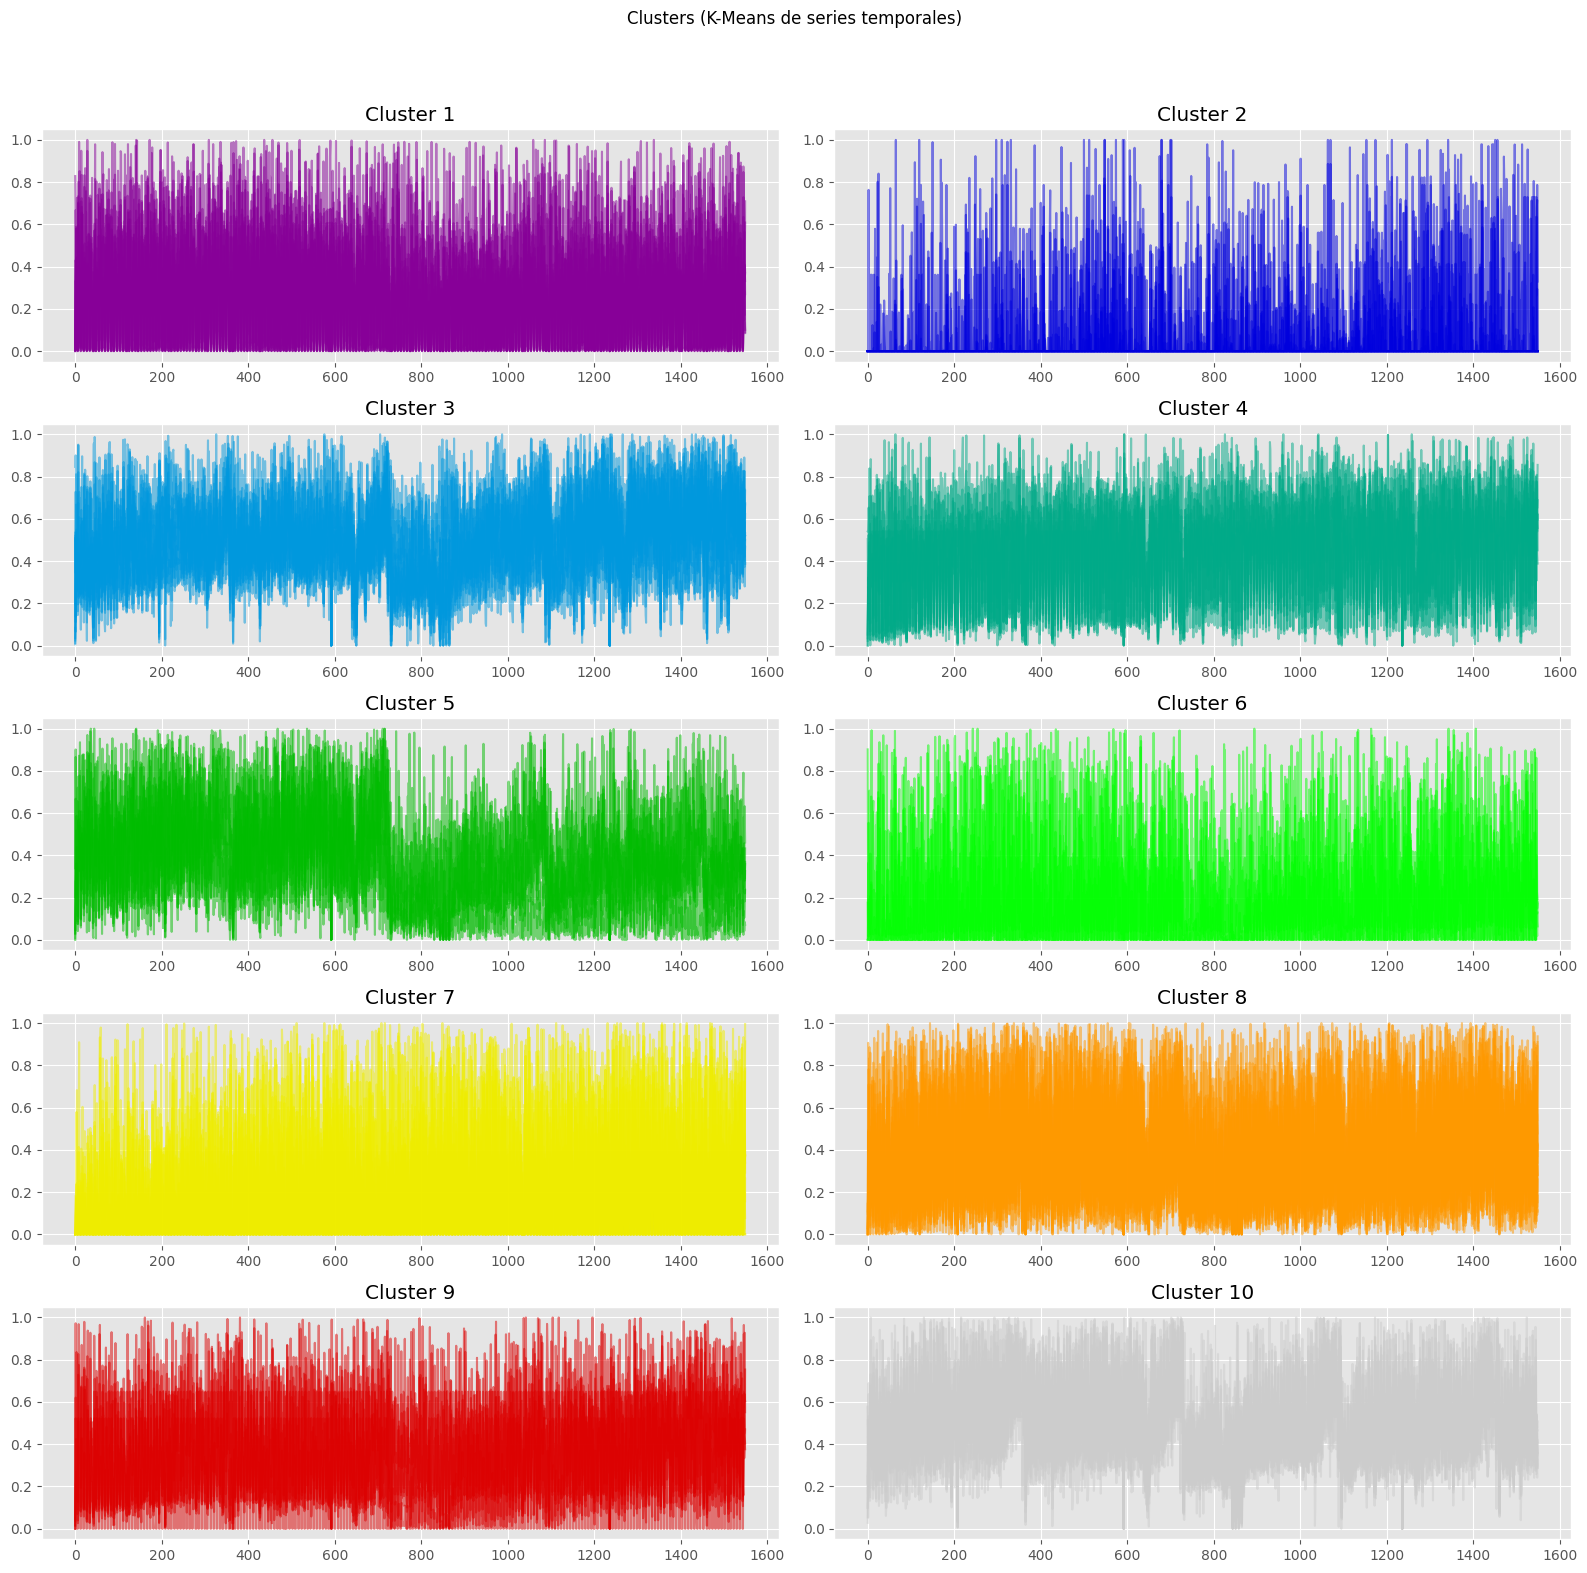

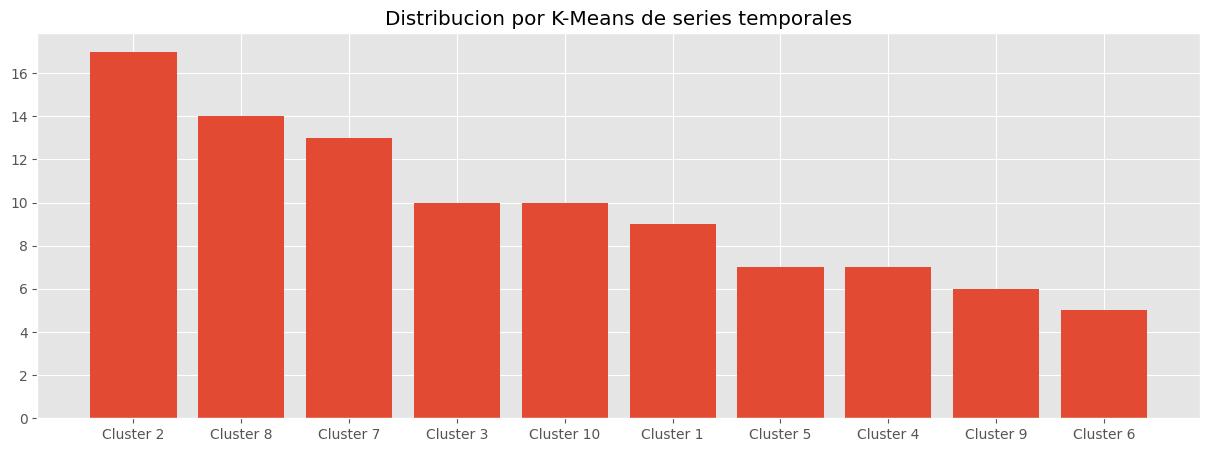

Cluster
Cluster 1      9
Cluster 10    10
Cluster 2     17
Cluster 3     10
Cluster 4      7
Cluster 5      7
Cluster 6      5
Cluster 7     13
Cluster 8     14
Cluster 9      6
Name: count, dtype: int64


In [29]:

# Configura el modelo K-Means de series temporales (TimeSeriesKMeans)
km = TimeSeriesKMeans(n_clusters=10, metric="dtw", random_state=321)

# Aplica K-Means de series temporales al conjunto de datos
labels_kmeans = km.fit_predict(X) + 1  # Agregar 1 a los índices

# Imprime los resultados de K-Means de series temporales
print("Resultados de K-Means de series temporales:")
print(labels_kmeans)

# Configuración de subplots para K-Means de series temporales
plot_rows_kmeans = 5
plot_cols_kmeans = 2

# Visualiza todos los clusters de K-Means de series temporales como subplots
fig_kmeans, axs_kmeans = plt.subplots(plot_rows_kmeans, plot_cols_kmeans, figsize=(16, 16))

fig_kmeans.suptitle('Clusters (K-Means de series temporales)')
row_i_kmeans = 0
column_j_kmeans = 0

for label in range(1, 11):  # Iniciar desde 1
    cluster_indices_kmeans = np.where(labels_kmeans == label)[0]
    cluster_series_kmeans = X[cluster_indices_kmeans]

    for i in cluster_indices_kmeans:
        axs_kmeans[row_i_kmeans, column_j_kmeans].plot(
            X[i].ravel(), c=plt.cm.nipy_spectral(label / 10), alpha=0.5)  # Se asume 10 clusters

    axs_kmeans[row_i_kmeans, column_j_kmeans].set_title(f'Cluster {label}')
    column_j_kmeans += 1

    if column_j_kmeans % plot_cols_kmeans == 0:
        row_i_kmeans += 1
        column_j_kmeans = 0

# Ajusta el diseño y muestra los subplots para K-Means de series temporales
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Grafico la distribución de los clusters para K-Means de series temporales
cluster_c_kmeans = [len(labels_kmeans[labels_kmeans == i]) for i in range(1, 11)]  # Iniciar desde 1
cluster_n_kmeans = ["Cluster " + str(i) for i in range(1, 11)]  # Iniciar desde 1
# Ordenar por cantidad de registros
cluster_c_kmeans, cluster_n_kmeans = zip(*sorted(zip(cluster_c_kmeans, cluster_n_kmeans), reverse=True))

plt.figure(figsize=(15, 5))
plt.title("Distribucion por K-Means de series temporales")
plt.bar(cluster_n_kmeans, cluster_c_kmeans)
plt.show()

# Asigno un nombre a cada cluster para K-Means de series temporales
fancy_names_for_labels_kmeans = [f"Cluster {label}" for label in labels_kmeans]
df_Cluster_KMeans_TS = pd.DataFrame(zip(ESPECIALIDAD, fancy_names_for_labels_kmeans),
                                     columns=["Series", "Cluster"]).sort_values(by="Cluster").set_index("Series")

# Frequencia de cada cluster para K-Means de series temporales
print(df_Cluster_KMeans_TS['Cluster'].value_counts().sort_index())

# Guardar el archivo xlsx para K-Means de series temporales
df_Cluster_KMeans_TS.to_excel("Cluster_KMeans_TS.xlsx")


### Agrupación jerárquica aglomerativa

Resultados de la agrupación aglomerativa:
[ 2  1  4  5  7  4  4  4  5  2  5  5  5  5  5  1  5  1  1  3  4  2  2  5
  2  1  2  4  2  9  4  8  1  1  5  4  2  2  4  1  4  4  5  2  4  5  4  5
  1  5  6  5  5  1  4  4  5  2  1  1  1  5  1  5  2  1  1  2  1  2  2  3
  1  4  5  5  2  1  1  1  2  4  1  2  2  4  4  5  2  2 10  1  5  1  4  1
  1  1]


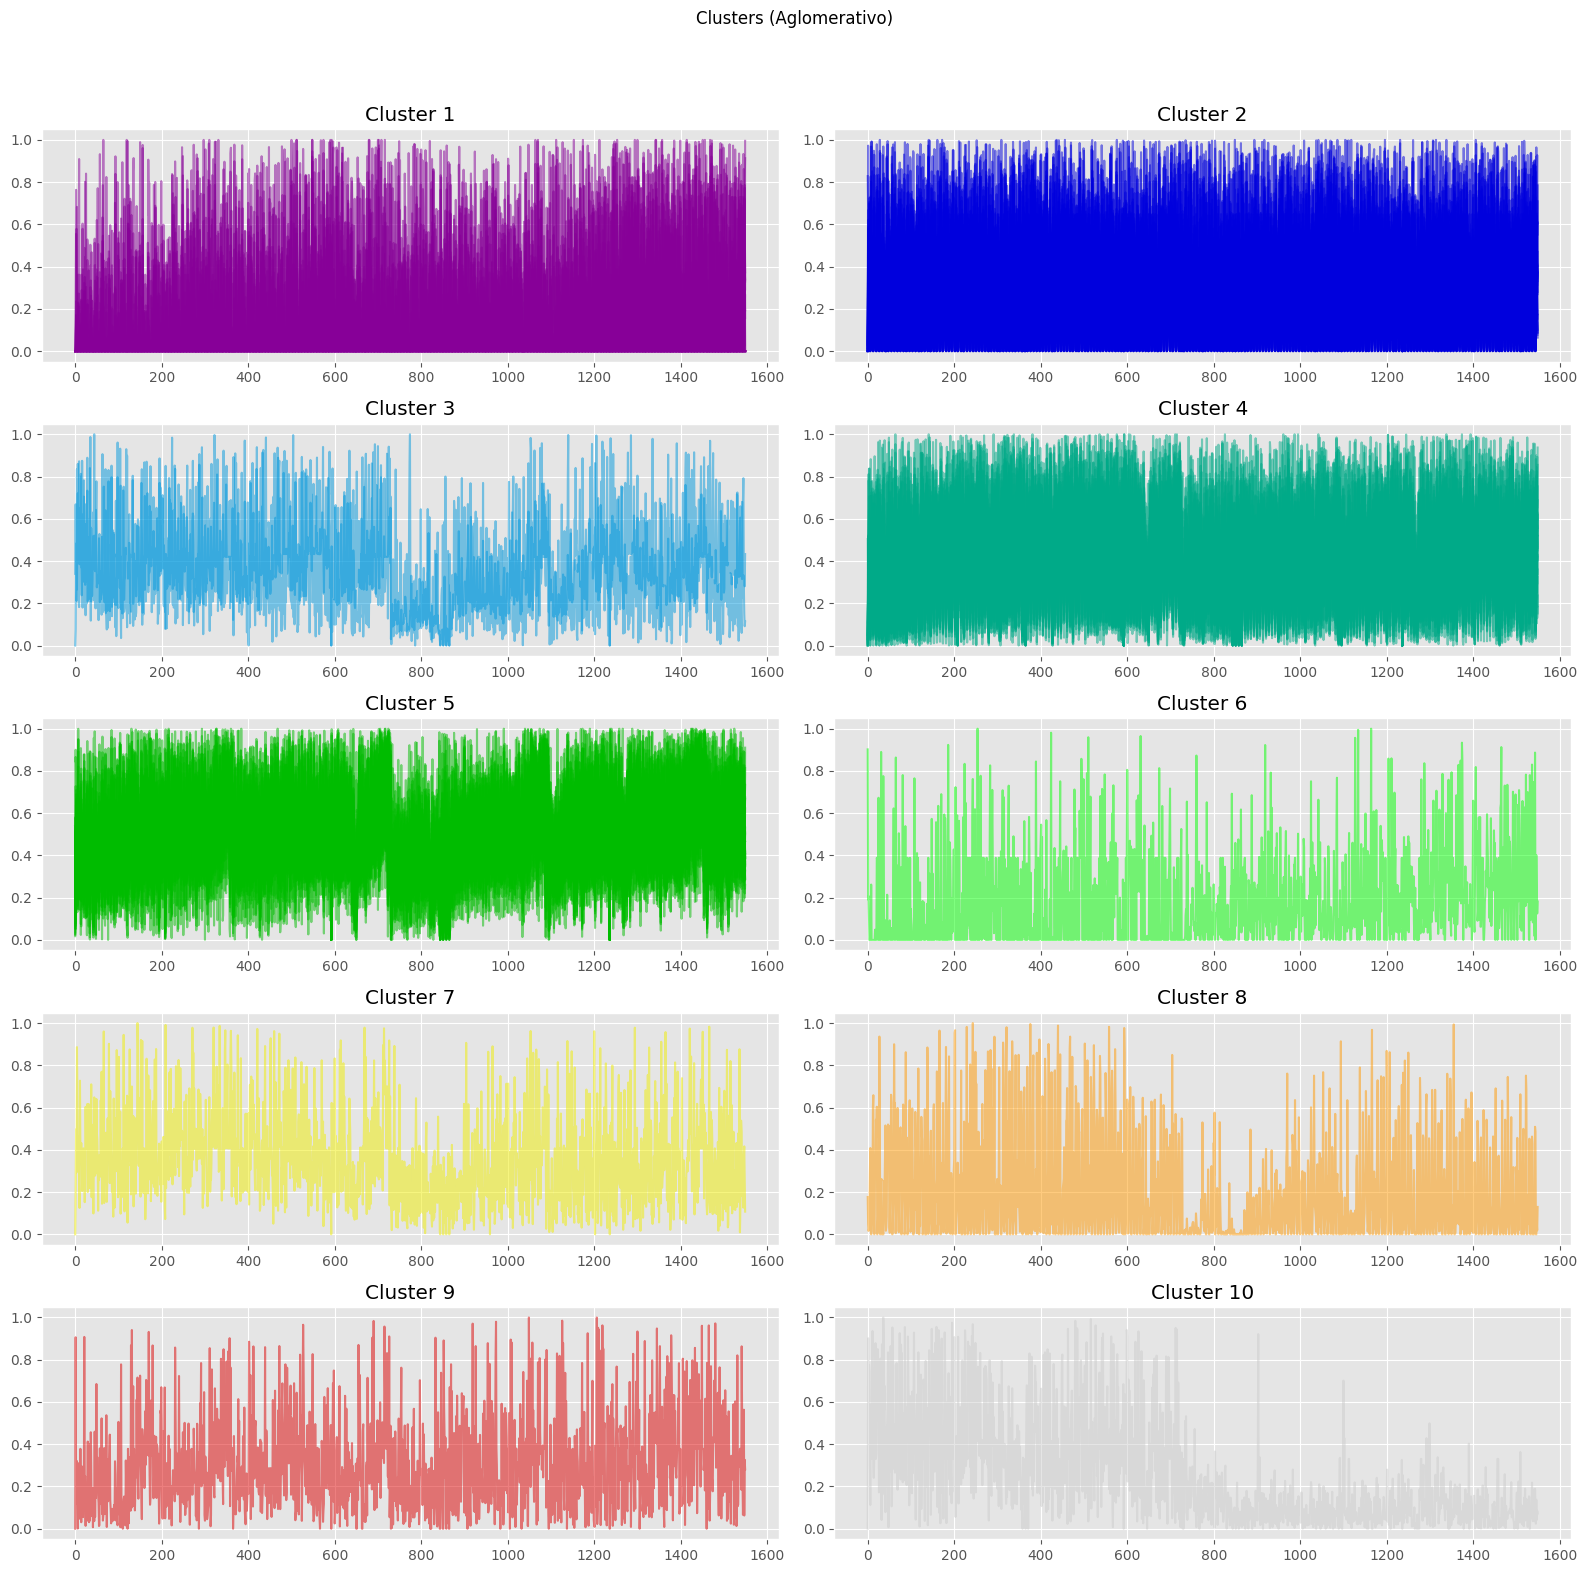

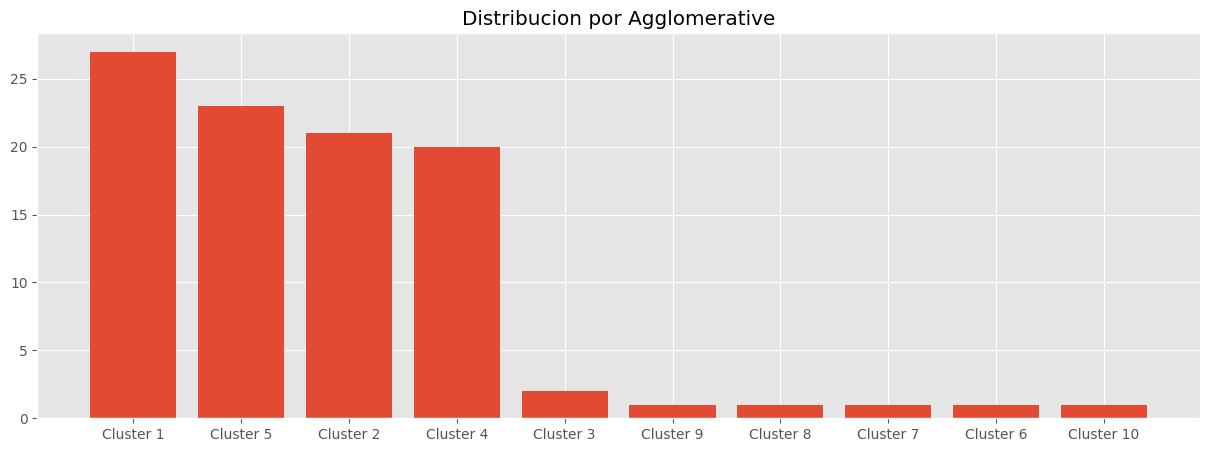

Cluster
Cluster 1     27
Cluster 10     1
Cluster 2     21
Cluster 3      2
Cluster 4     20
Cluster 5     23
Cluster 6      1
Cluster 7      1
Cluster 8      1
Cluster 9      1
Name: count, dtype: int64


In [30]:
# Calcula la matriz de distancias (puedes usar la métrica que prefieras)
distance_matrix = pairwise_distances(X, metric="euclidean")

# Aplica la agrupación aglomerativa
agglomerative = AgglomerativeClustering(n_clusters=cluster_count, affinity="precomputed", linkage="average")
labels = agglomerative.fit_predict(distance_matrix) + 1  # Agregar 1 a los índices
label = agglomerative

# Imprime los resultados de la agrupación aglomerativa
print("Resultados de la agrupación aglomerativa:")
print(labels)

# Configuración de subplots para la agrupación aglomerativa
plot_rows_agglomerative = 5
plot_cols_agglomerative = 2

# Visualiza todos los clusters de la agrupación aglomerativa como subplots
fig_agglomerative, axs_agglomerative = plt.subplots(plot_rows_agglomerative, plot_cols_agglomerative, figsize=(16, 16))

fig_agglomerative.suptitle('Clusters (Aglomerativo)')
row_i_agglomerative = 0
column_j_agglomerative = 0

for label in range(1, cluster_count + 1):  # Iniciar desde 1
    cluster_indices_agglomerative = np.where(labels == label)[0]
    cluster_series_agglomerative = X[cluster_indices_agglomerative]

    for i in cluster_indices_agglomerative:
        axs_agglomerative[row_i_agglomerative, column_j_agglomerative].plot(
            X[i].ravel(), c=plt.cm.nipy_spectral(label / float(cluster_count)), alpha=0.5)

    axs_agglomerative[row_i_agglomerative, column_j_agglomerative].set_title(f'Cluster {label}')
    column_j_agglomerative += 1

    if column_j_agglomerative % plot_cols_agglomerative == 0:
        row_i_agglomerative += 1
        column_j_agglomerative = 0

# Ajusta el diseño y muestra los subplots para la agrupación aglomerativa
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Grafico la distribución de los clusters
cluster_c = [len(labels[labels==i]) for i in range(1, cluster_count + 1)]
cluster_n = ["Cluster "+str(i) for i in range(1, cluster_count + 1)]
# Ordenar por cantidad de registros
cluster_c, cluster_n = zip(*sorted(zip(cluster_c, cluster_n), reverse=True))
plt.figure(figsize=(15,5))
plt.title("Distribucion por Agglomerative")
plt.bar(cluster_n, cluster_c)
plt.show()


# Asigno un nombre a cada cluster
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
df_Cluster_CA = pd.DataFrame(zip(ESPECIALIDAD,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

# Frequencia de cada cluster
print(df_Cluster_CA['Cluster'].value_counts().sort_index())

# Guardar el archivo xlsx
df_Cluster_CA.to_excel("Cluster_CA.xlsx")


### kShape

0.441 --> Resumed because of empty cluster
0.411 --> 0.321 --> 0.315 --> 0.313 --> 0.311 --> 0.311 --> 0.311 --> 
Resultados de KShape:
[ 9  1  3  3  2  3  5  3  3  3  3  3  3  3  3  1  3  4  1  3  3  3  3  3
  1  3  9  3  1  3  3  3  4  3  3  3  8  3  3  1  3  3  3  3  3  3  3  3
  6  3  3  3  3  3  3  3  3  3  3  6  3  3  3  3  1  6  7  3  7  1  1 10
  6  3  3  3  9  1  1  3  9  3  1  1  9  3  3  3  3  3  3  6  3  3  3  3
  3  3]


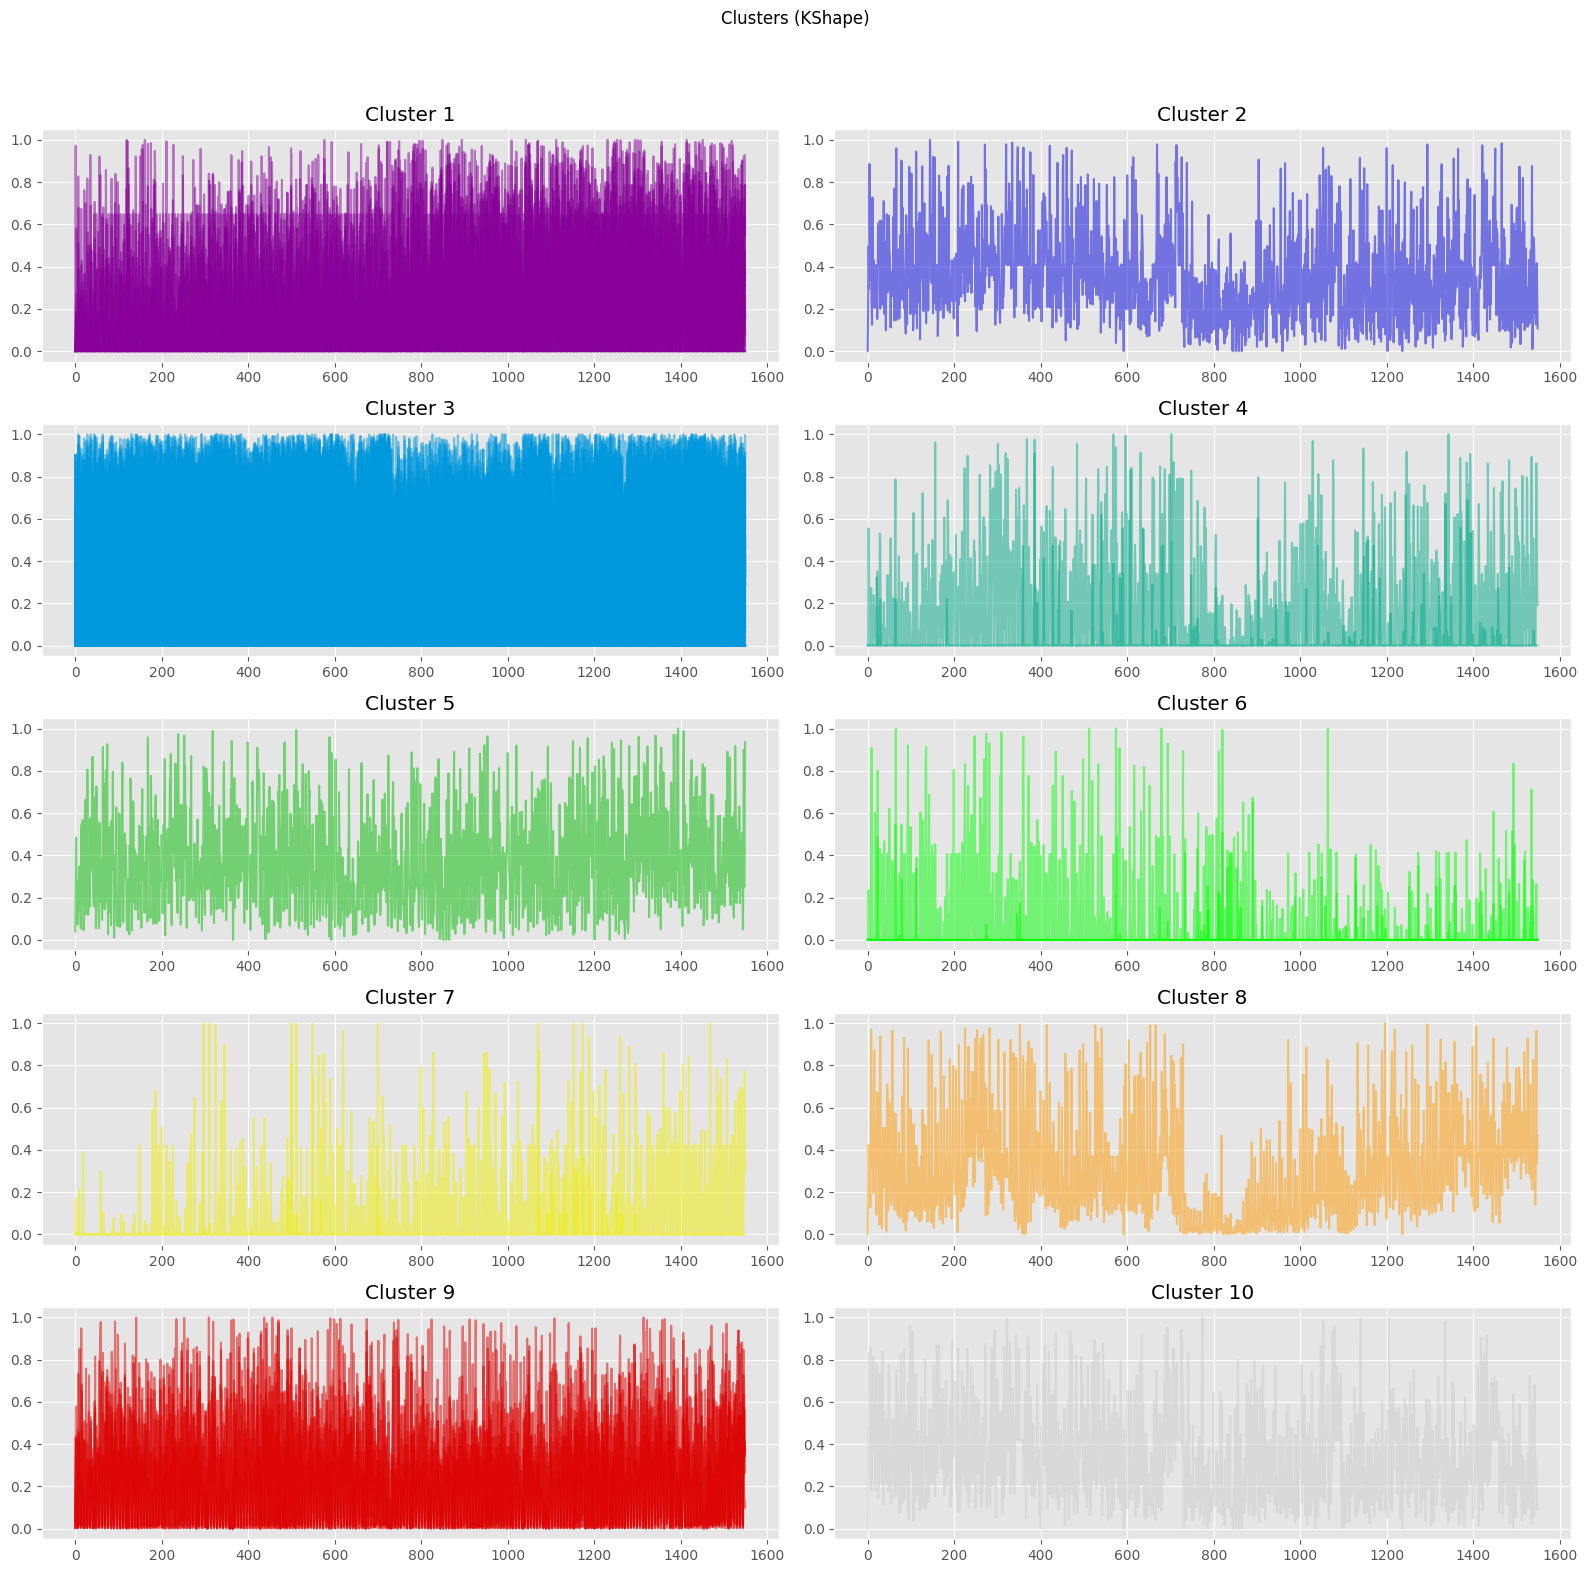

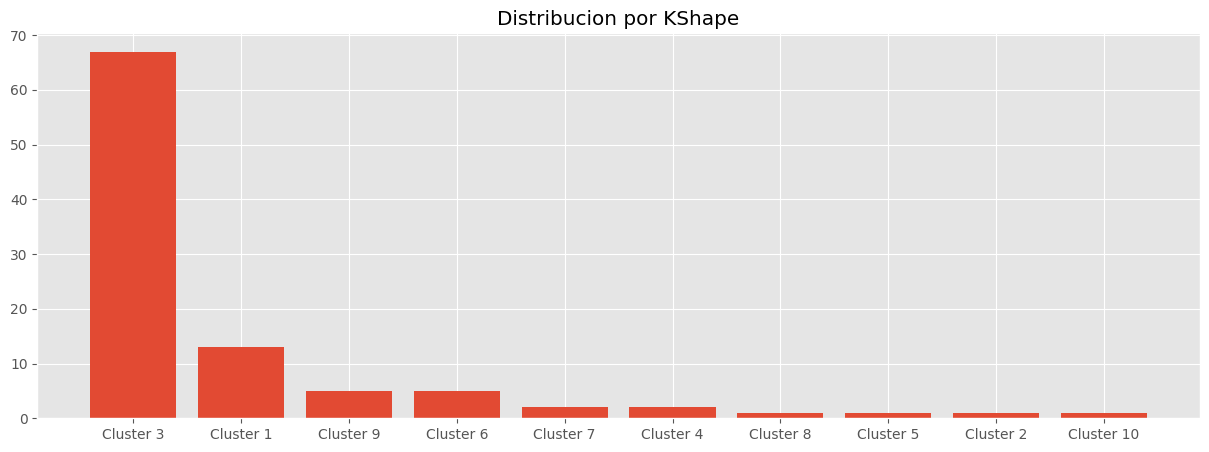

Cluster
Cluster 10     5
Cluster 11     1
Cluster 2     13
Cluster 3      1
Cluster 4     67
Cluster 5      2
Cluster 6      1
Cluster 7      5
Cluster 8      2
Cluster 9      1
Name: count, dtype: int64


In [31]:
# Configura el modelo KShape
kshape_model = KShape(n_clusters=cluster_count, verbose=True)

# Aplica KShape al conjunto de datos
labels_kshape = kshape_model.fit_predict(X) + 1  
labels = labels_kshape
label = labels_kshape

# Imprime los resultados de KShape
print("Resultados de KShape:")
print(labels_kshape)

# Configuración de subplots para KShape
plot_rows_kshape = 5
plot_cols_kshape = 2

# Visualiza todos los clusters de KShape como subplots
fig_kshape, axs_kshape = plt.subplots(plot_rows_kshape, plot_cols_kshape, figsize=(16, 16))

fig_kshape.suptitle('Clusters (KShape)')
row_i_kshape = 0
column_j_kshape = 0

for label in range(1, cluster_count + 1):  # Iniciar desde 1
    cluster_indices_kshape = np.where(labels_kshape == label)[0]
    cluster_series_kshape = X[cluster_indices_kshape]

    for i in cluster_indices_kshape:
        axs_kshape[row_i_kshape, column_j_kshape].plot(
            X[i].ravel(), c=plt.cm.nipy_spectral(label / float(cluster_count)), alpha=0.5)

    axs_kshape[row_i_kshape, column_j_kshape].set_title(f'Cluster {label}')
    column_j_kshape += 1

    if column_j_kshape % plot_cols_kshape == 0:
        row_i_kshape += 1
        column_j_kshape = 0

# Ajusta el diseño y muestra los subplots para KShape
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Grafico la distribución de los clusters
cluster_c = [len(labels[labels == i]) for i in range(1, cluster_count + 1)]  # Iniciar desde 1
cluster_n = ["Cluster " + str(i) for i in range(1, cluster_count + 1)]  # Iniciar desde 1
# Ordenar por cantidad de registros
cluster_c, cluster_n = zip(*sorted(zip(cluster_c, cluster_n), reverse=True))

plt.figure(figsize=(15, 5))
plt.title("Distribucion por KShape")
plt.bar(cluster_n, cluster_c)
plt.show()
# Asigno un nombre a cada cluster
fancy_names_for_labels = [f"Cluster {label+1}" for label in labels]
df_Cluster_KS = pd.DataFrame(zip(ESPECIALIDAD,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

# Frequencia de cada cluster
print(df_Cluster_KS['Cluster'].value_counts().sort_index())

# Guardar el archivo xlsx
df_Cluster_KS.to_excel("Cluster_KS.xlsx")

###  kernel K-Means

Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resultados de Kernel K-Means:
[ 5  2  8  8  8  8  8  3  8 10  7  8  8  8  7  2  7  2  3  3  8  8  5  8
  5  2  5  8  5 10  8  4  3  2  8  8  3  5  8  1  8  8  8  5  3  8  8  8
  2 10  1  8  8  2  8  8 10  5  2  2  2  8  2  8 10  2  3 10  2  5  5  7
  2  8  8  8  5  3  1  2  5  8  3 10  5 10  8  8  5  5  2  2  8  3  8  2
  2  3]


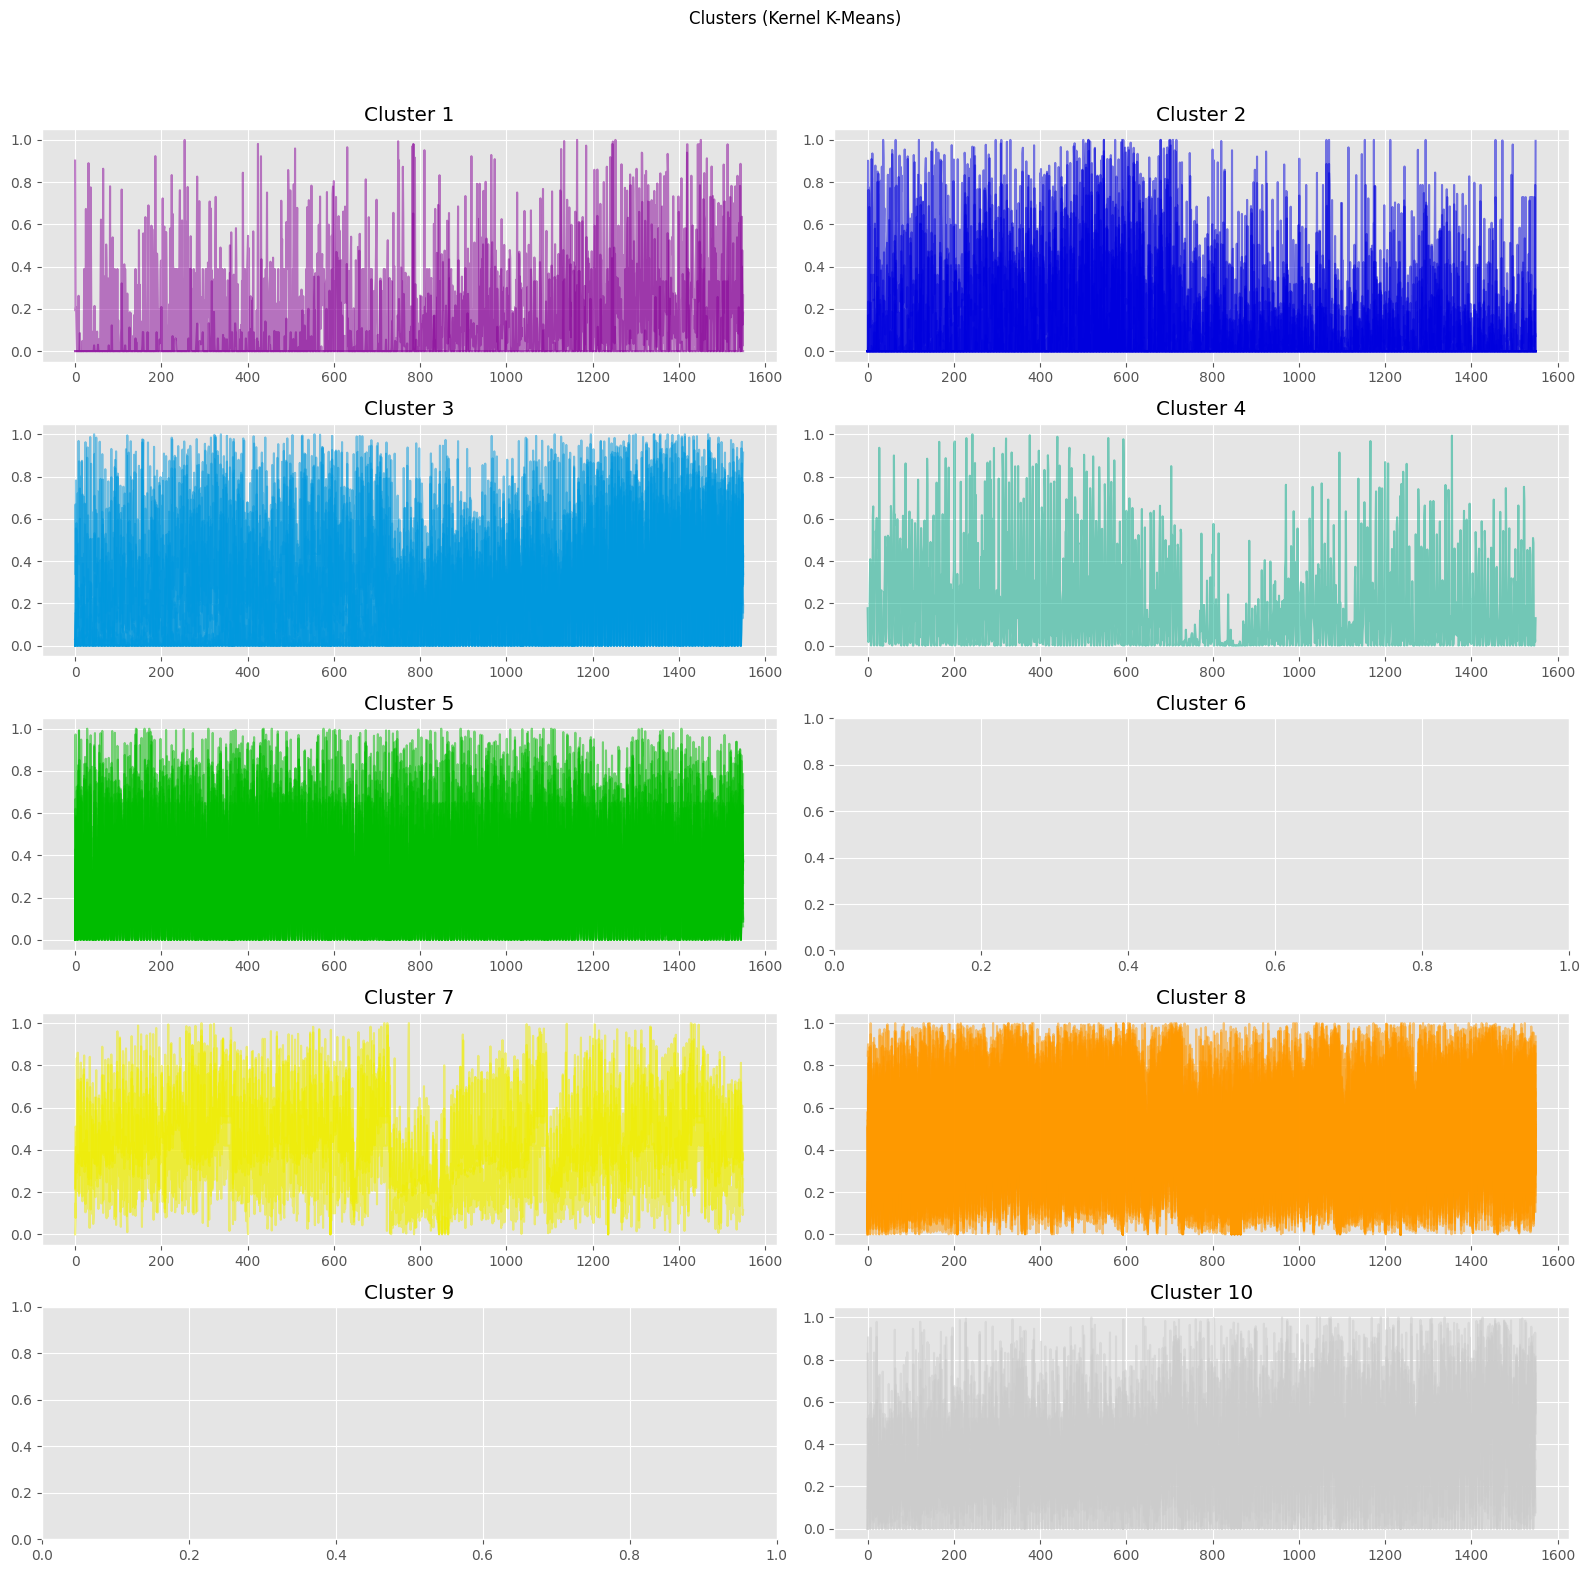

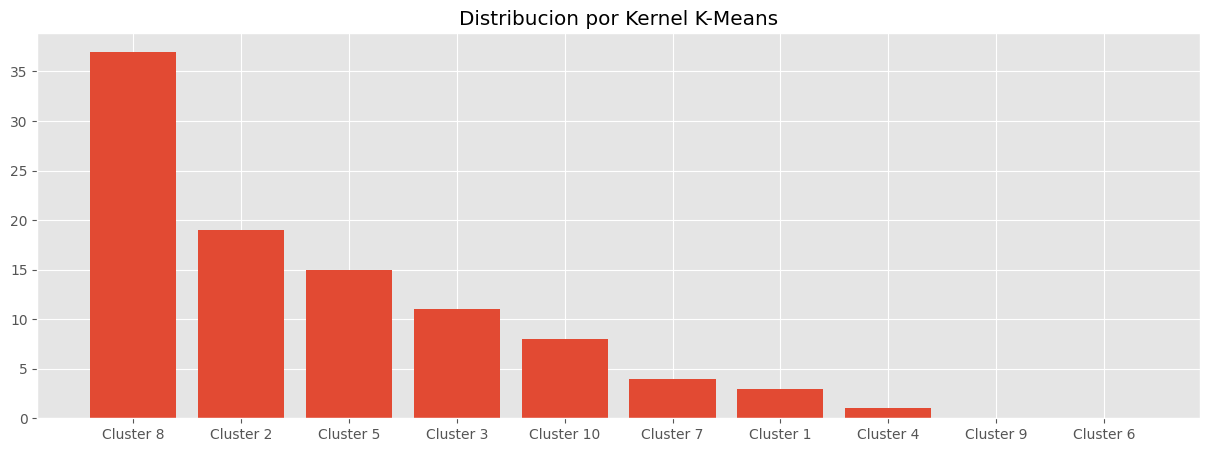

Cluster
Cluster 1      3
Cluster 10     8
Cluster 2     19
Cluster 3     11
Cluster 4      1
Cluster 5     15
Cluster 7      4
Cluster 8     37
Name: count, dtype: int64


In [43]:
# Establece una semilla para reproducibilidad
random.seed(123)
np.random.seed(123)

# Kernel K-Means
sigma = 0.5  # Ajusta el ancho del kernel gaussiano
kernel_kmeans_model = KernelKMeans(n_clusters=cluster_count, kernel="rbf", verbose=True, random_state=123)
labels_kernel_kmeans = kernel_kmeans_model.fit_predict(X) + 1  # Agregar 1 a los índices
labels = labels_kernel_kmeans

# Imprime los resultados de Kernel K-Means
print("Resultados de Kernel K-Means:")
print(labels_kernel_kmeans)

# Configuración de subplots para Kernel K-Means
plot_rows_kernel_kmeans = 5
plot_cols_kernel_kmeans = 2

# Visualiza todos los clusters de Kernel K-Means como subplots
fig_kernel_kmeans, axs_kernel_kmeans = plt.subplots(plot_rows_kernel_kmeans, plot_cols_kernel_kmeans, figsize=(16, 16))

fig_kernel_kmeans.suptitle('Clusters (Kernel K-Means)')
row_i_kernel_kmeans = 0
column_j_kernel_kmeans = 0

for label in range(1, cluster_count + 1):  # Iniciar desde 1
    cluster_indices_kernel_kmeans = np.where(labels_kernel_kmeans == label)[0]
    cluster_series_kernel_kmeans = X[cluster_indices_kernel_kmeans]

    for i in cluster_indices_kernel_kmeans:
        axs_kernel_kmeans[row_i_kernel_kmeans, column_j_kernel_kmeans].plot(
            X[i].ravel(), c=plt.cm.nipy_spectral(label / float(cluster_count)), alpha=0.5)

    axs_kernel_kmeans[row_i_kernel_kmeans, column_j_kernel_kmeans].set_title(f'Cluster {label}')
    column_j_kernel_kmeans += 1

    if column_j_kernel_kmeans % plot_cols_kernel_kmeans == 0:
        row_i_kernel_kmeans += 1
        column_j_kernel_kmeans = 0

# Ajusta el diseño y muestra los subplots para Kernel K-Means
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Grafico la distribución de los clusters
cluster_c = [len(labels[labels == i]) for i in range(1, cluster_count + 1)]  # Iniciar desde 1
cluster_n = ["Cluster " + str(i) for i in range(1, cluster_count + 1)]  # Iniciar desde 1
# Ordenar por cantidad de registros
cluster_c, cluster_n = zip(*sorted(zip(cluster_c, cluster_n), reverse=True))

plt.figure(figsize=(15, 5))
plt.title("Distribucion por Kernel K-Means")
plt.bar(cluster_n, cluster_c)
plt.show()

# Asigno un nombre a cada cluster
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
df_Cluster_KKM = pd.DataFrame(zip(ESPECIALIDAD,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

# Frequencia de cada cluster
print(df_Cluster_KKM['Cluster'].value_counts().sort_index())

# Guardar el archivo xlsx
df_Cluster_KKM.to_excel("Cluster_KKM.xlsx")

### Compilo todos los clusters

In [44]:
# cambiar el nombre de la columna cluster de los 4 archivos por cluster
df_Cluster_KMeans_TS.rename(columns={'Cluster': 'Cluster_KM'}, inplace=True)
df_Cluster_CA.rename(columns={'Cluster': 'Cluster_CA'}, inplace=True)
df_Cluster_KS.rename(columns={'Cluster': 'Cluster_KS'}, inplace=True)
df_Cluster_KKM.rename(columns={'Cluster': 'Cluster_KKM'}, inplace=True)

# unir los 4 archivos
df_Cluster = pd.concat([df_Cluster_KMeans_TS, df_Cluster_CA, df_Cluster_KS, df_Cluster_KKM], axis=1)
display(df_Cluster.head())

# Guardar el archivo xlsx
df_Cluster.to_excel("df_Cluster_4_models_.xlsx")

,Cluster_KM,Cluster_CA,Cluster_KS,Cluster_KKM
Series,,,,
DISCOTECAS,Cluster 1,Cluster 2,Cluster 4,Cluster 5
VENTA PUERTA A PUERTA,Cluster 1,Cluster 2,Cluster 4,Cluster 5
DISTRIBUIDOR DE CAMPINGS,Cluster 1,Cluster 2,Cluster 10,Cluster 5
VENTA CATALOGO,Cluster 1,Cluster 2,Cluster 10,Cluster 5
SERVICIO MISCELANEOS PRIV,Cluster 1,Cluster 2,Cluster 10,Cluster 5


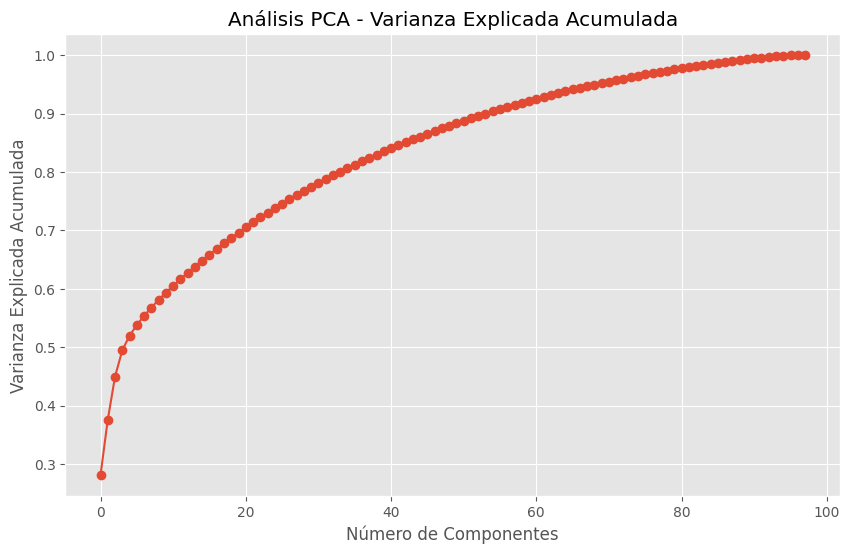

array([0.28110818, 0.37603243, 0.44978259, 0.49500634, 0.51995341,
       0.53828018, 0.55390451, 0.5681361 , 0.58141696, 0.59368155,
       0.60535092, 0.61666594, 0.62774992, 0.63830284, 0.64856385,
       0.65879767, 0.66862094, 0.67815494, 0.68735665, 0.69631581,
       0.70521043, 0.71393898, 0.72241906, 0.73040541, 0.73832864,
       0.74603347, 0.75370717, 0.76107435, 0.76826144, 0.77511187,
       0.78178161, 0.78824264, 0.79450878, 0.8006871 , 0.80680399,
       0.8127985 , 0.81850884, 0.82420405, 0.82985813, 0.83530152,
       0.84061102, 0.84584759, 0.85092669, 0.85593996, 0.8608794 ,
       0.8656508 , 0.87030833, 0.87486022, 0.87929636, 0.88371561,
       0.88793461, 0.89208871, 0.89613918, 0.90013115, 0.90405654,
       0.90792172, 0.91173872, 0.9154481 , 0.91893624, 0.92242183,
       0.92583902, 0.92909416, 0.93229755, 0.93535478, 0.93838343,
       0.94136363, 0.94422768, 0.94702168, 0.94978521, 0.9524215 ,
       0.95499421, 0.95752755, 0.96004062, 0.96249879, 0.96484

In [45]:

from sklearn.decomposition import FactorAnalysis, PCA

# Excluir la columna de identificación
#data_for_pca = df_Frec.drop('Desc_Especialidad', axis=1)df_Frec
data_for_pca = df_Frec


# Aplicar PCA
pca = PCA()
pca.fit(data_for_pca)

# Calcular la varianza explicada acumulada
varianza_explicada_acumulada = pca.explained_variance_ratio_.cumsum()

# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(varianza_explicada_acumulada, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Análisis PCA - Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

varianza_explicada_acumulada

In [46]:
# Extraer las cargas de los primeros componentes principales
num_componentes = 2
cargas = pca.components_[:num_componentes]
cargas = cargas.T
cargas = preprocessing.normalize(cargas)

# Crear un DataFrame para facilitar la visualización
cargas_df = pd.DataFrame(cargas, index=data_for_pca.columns, columns=[f'Componente {i+1}' for i in range(num_componentes)])

display(cargas_df.head(5))

,Componente 1,Componente 2
Desc_Especialidad,,
ACADEMIAS,-0.99,0.17
AG.EMPLEO-SERVICIO DE AYUD,-0.60,0.80
AGENCIAS DE VIAJES,-0.50,-0.86
ALMACEN POR DEPARTAMENTOS,-0.84,-0.55
ALMACENES DE DISCOS,-0.04,-1.00


In [47]:


n_clusters = 11
# Seleccionar solo las características numéricas (componentes principales)
features = cargas_df.iloc[:, 1:]


# Aplicar K-means con la distancia del coseno
kmeans = KMeans(n_clusters,random_state=0)
clusters = kmeans.fit_predict(features)

# Agregar la asignación de cluster a los datos originales
data_with_clusters = features
# anteponer Cluster al nombre de la columna
data_with_clusters['Cluster'] = clusters



# Agregar la asignación de Cluster

# Mostrar los primeros registros con su cluster asignado
data_with_clusters = data_with_clusters[['Cluster']]
data_with_clusters.head()


,Cluster
Desc_Especialidad,
ACADEMIAS,1
AG.EMPLEO-SERVICIO DE AYUD,3
AGENCIAS DE VIAJES,8
ALMACEN POR DEPARTAMENTOS,2
ALMACENES DE DISCOS,0


In [48]:
# Distribución de los clusters
data_with_clusters['Cluster'].value_counts().sort_index()


Cluster
0     16
1     13
2      6
3      7
4      6
5      8
6      7
7     12
8     15
9      5
10     3
Name: count, dtype: int64

In [49]:
# Analisis de silueta
silhouette_score(features, clusters, metric='euclidean')


0.9606137470520817

In [50]:
#exportar el archivo
data_with_clusters.to_excel("data_with_clusters_acp.xlsx")